# Professions: comparison

In the following notebook we're going to compare all the approaches we developed and test them on a small amount of professions for which we have precise statics about. We will use both FastText's and Gonen's embeddings.

In [1]:
# general
import pandas as pd
import numpy as np
import scipy.stats
import codecs
from matplotlib import pyplot as plt
from numpy import linalg as LA

# bolukbasi's
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding

# mine
import db_functions as db

### Step 1: Load embeddings

We load all the emdeddings using the same methods and applying the same preprocessing in order to have a common start.

In [2]:
# load Gonen's emdebbings
E_g =  WordEmbedding('../embedding/gonen/it_lemma_to_fem', 'g')

*** Reading data from ../embedding/gonen/it_lemma_to_fem
(160597, 300)
160597 words of dimension 300 : </s>, ,, di, ., ..., title="henrik, pass">, title="nils, title="derrick
160597 words of dimension 300 : </s>, ,, di, ., ..., title="henrik, pass">, title="nils, title="derrick


In [2]:
# load FastText's emdeddings
E_ft =  WordEmbedding('../embedding/fast-text/cc.it.300.reduced.vec', 'ft')

*** Reading data from ../embedding/fast-text/cc.it.300.reduced.vec
(485, 300)
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica


### Step 2: working whit FastText's embeddings

#### Step 2.1: vector difference

In [3]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

#### Step 2.2: PCA

In [4]:
# list of pairs to define gender
'''
gender_pairs = [['lei','lui'],
                ['donna','uomo'], 
                ['madre','padre'],
                ['moglie','marito'],
                ['sorella','fratello'],
                ['femmina','maschio']]
'''

gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [5]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [6]:
print("Singular values:")
print(sv)

Singular values:
[9.5309240e-01 5.3566736e-01 3.7772956e-01 3.4538972e-01 2.9901835e-01
 2.4023318e-01 5.8411594e-08 4.6098762e-08 4.3273410e-08 4.1712632e-08]


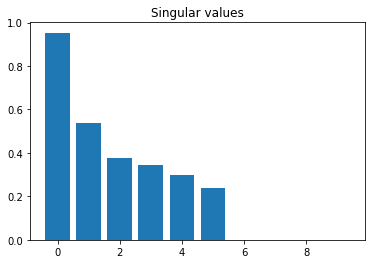

In [7]:
#fig = plt.figure(figsize=(10,7))    
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()
#fig.savefig('pca.png')

In [8]:
var = pca.explained_variance_
print(var)

[8.2580462e-02 2.6085412e-02 1.2970874e-02 1.0844915e-02 8.1283608e-03
 5.2465438e-03 3.1017404e-16 1.9319055e-16 1.7023528e-16 1.5817669e-16]


In [9]:
s=0
for e in var:
    s = s+e
print(s)
print(var[0]/s)

0.1458565681241461
0.5661758202608547


In [10]:
pca.explained_variance_ratio_

array([5.6617582e-01, 1.7884290e-01, 8.8928968e-02, 7.4353285e-02,
       5.5728450e-02, 3.5970569e-02, 2.1265688e-15, 1.3245241e-15,
       1.1671416e-15, 1.0844674e-15], dtype=float32)

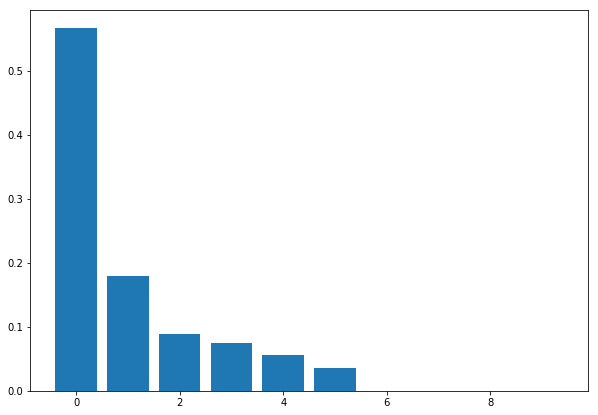

In [11]:
fig = plt.figure(figsize=(10,7))    
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.show()
fig.savefig('pca-it.pdf', format='pdf')

In [12]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

#### Step 2.3: pseudo-LDA

In [13]:
'''
S_word = [['lei','lui'],
          ['donna','uomo'],
          ['madre','padre'],
          ['moglie','marito'],
          ['sorella','fratello'],
          ['femmina','maschio']]
'''

S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [14]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [15]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [16]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

#### Step 2.4: compute projections

##### Ungendered professions

In [17]:
# read professions
prof_ung_truth = db.read('professions_ung.csv', 'truth')

In [18]:
# compute projection of each profession on g_diff
proj_ung_g_diff = db.prof_proj(E_ft, prof_ung_truth, g_diff, 'istat')

# compute projection of each profession on g_pca_0
proj_ung_g_pca_0 = db.prof_proj(E_ft, prof_ung_truth, g_pca_0, 'istat')

# compute projection of each profession on g_pca_01
proj_ung_g_pca_01 = db.prof_proj(E_ft, prof_ung_truth, g_pca_01, 'istat')

# compute projection of each profession on g_e
proj_ung_g_e = db.prof_proj(E_ft, prof_ung_truth, g_e, 'istat')

In [19]:
# print results
ung_col0 = [] # pandas columns
ung_col1 = []
ung_col2 = []
ung_col3 = []
ung_col4 = []
ung_col5 = []
ung_col6 = []

for i in range(len(proj_ung_g_diff)):
    ung_col0.append(proj_ung_g_diff[i][0]) # profession
    ung_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    ung_col2.append(proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    ung_col3.append(proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    ung_col4.append(np.real(proj_ung_g_e[i][1])) # projection on g_e
    ung_col5.append(proj_ung_g_diff[i][2]) # %male
    ung_col6.append(proj_ung_g_diff[i][3]) # %female

    
ung_data = {'Profession':ung_col0, 
           'Proj g_diff':ung_col1,
           'Proj g_pca_0':ung_col2, 
           'Proj g_pca_01':ung_col3,
           'Prog g_e':ung_col4,
           '% male':ung_col5, 
           '% female':ung_col6}
ung_table = pd.DataFrame(ung_data)
ung_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% male,% female
0,camionista,0.027856,0.102896,0.050494,0.065189,96.9,3.1
1,elettricista,0.073085,0.122825,0.115196,0.019939,96.8,3.2
2,ingegnere,0.043748,0.217653,0.167188,0.026228,83.6,16.4
3,architetto,0.076696,0.183021,0.165500,0.059626,64.7,35.3
4,notaio,0.082010,0.171843,0.112616,0.022859,66.4,33.6
5,commercialista,0.024475,0.113249,0.061505,0.053153,68.2,31.8
6,giornalista,-0.048235,0.050688,-0.002423,-0.006167,54.7,45.3
7,insegnante,-0.103818,-0.055340,-0.070229,0.020056,17.3,82.7
8,barista,0.027839,0.052001,0.019284,0.062231,38.9,61.1
9,medico,-0.004724,0.135863,0.039559,-0.040868,56.3,43.7


In [20]:
#ung_table.to_csv('truth_ung_ft.csv', index=False)

In [21]:
# pearson correlation
r_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[0]
r_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[0]
r_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[0]
r_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[0]

p_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[1]
p_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[1]
p_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[1]
p_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[1]

In [22]:
pearson_data = {'g_diff':[r_g_diff,p_g_diff],
                'g_pca_0':[r_g_pca_0,p_g_pca_0],
                'g_pca_01':[r_g_pca_01,p_g_pca_01],
                'g_e':[r_g_e,p_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.810652,-0.79832,-0.796630,-0.431935
p,0.000140,0.00021,0.000221,0.094775


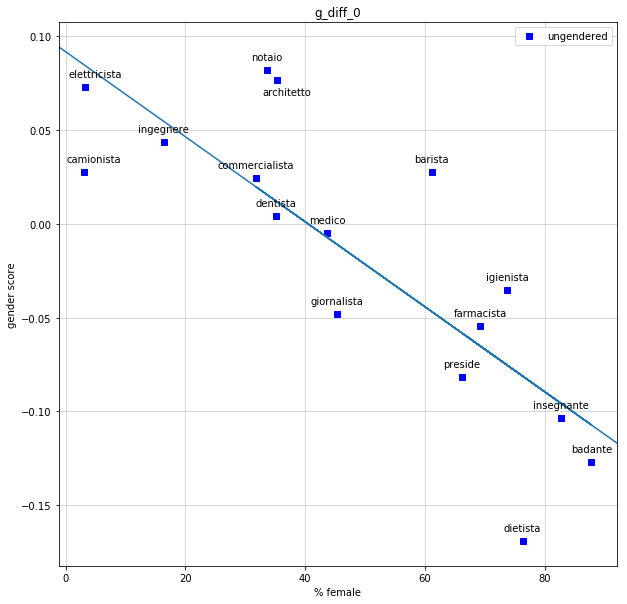

In [31]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)

ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend()

for i, label in enumerate(ung_col0):
    if label=='elettricista' or label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
    
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
    
plt.show()
fig.savefig('plot/ung/correlation/ft_g_diff.pdf', bbox_inches='tight', format='pdf')

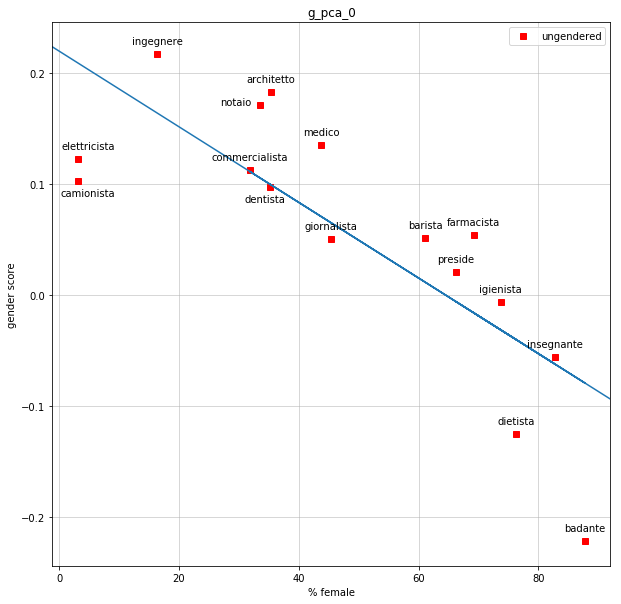

In [32]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    if label=='elettricista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='notaio':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-25,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dentista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-5,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/ft_g_pca_0.pdf', bbox_inches='tight', format='pdf')

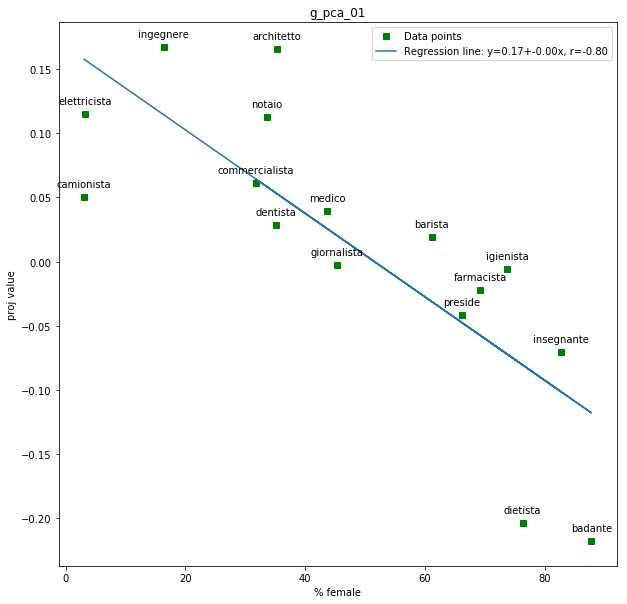

In [25]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")

ax.legend(facecolor='white')
for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/ft_g_pca_01')

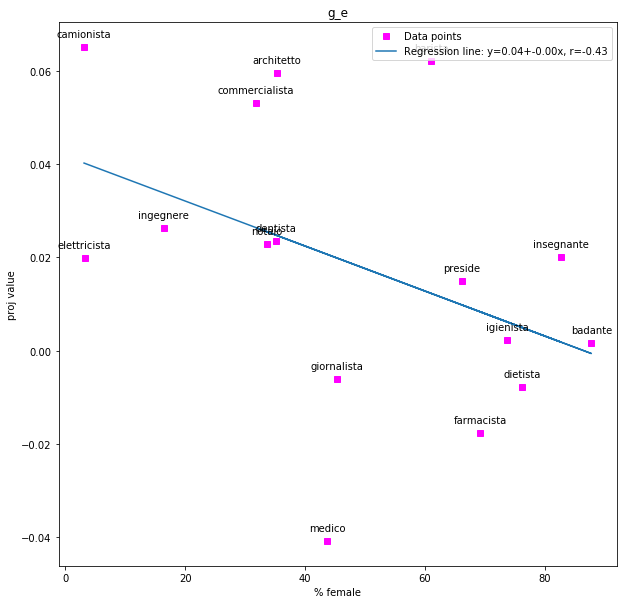

In [26]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/ft_g_e')

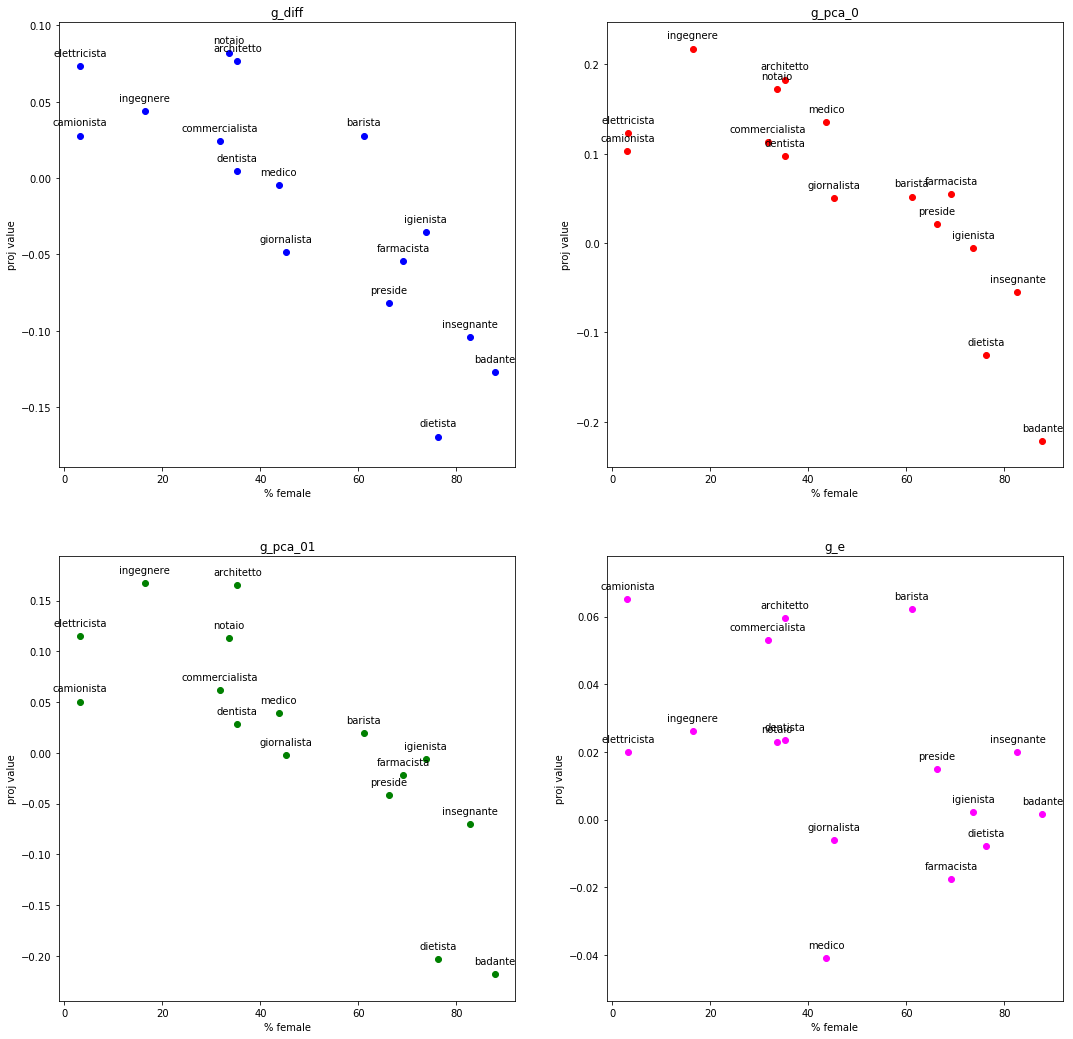

In [27]:
# scatter plots

plt.figure(figsize=(18,18))    

ax1 = plt.subplot(221)
ax1.scatter(ung_col6, ung_col1, c='blue')
ax1.set_title('g_diff')
ax1.set_xlabel('% female')
ax1.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax2 = plt.subplot(222)
ax2.scatter(ung_col6, ung_col2, c='red')
ax2.set_title('g_pca_0')
ax2.set_xlabel('% female')
ax2.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax3 = plt.subplot(223)
ax3.scatter(ung_col6, ung_col3, c='green')
ax3.set_title('g_pca_01')
ax3.set_xlabel('% female')
ax3.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
ax4 = plt.subplot(224)
ax4.scatter(ung_col6, ung_col4, c='magenta')
ax4.set_title('g_e')
ax4.set_xlabel('% female')
ax4.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()
fig.savefig('plot/ung/scatter/ft_all')

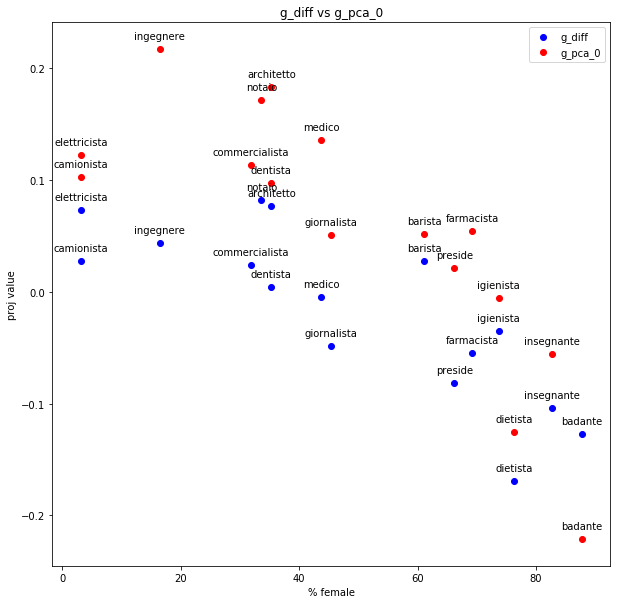

In [28]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.set_title('g_diff vs g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_g_diff_vs_g_pca_0')

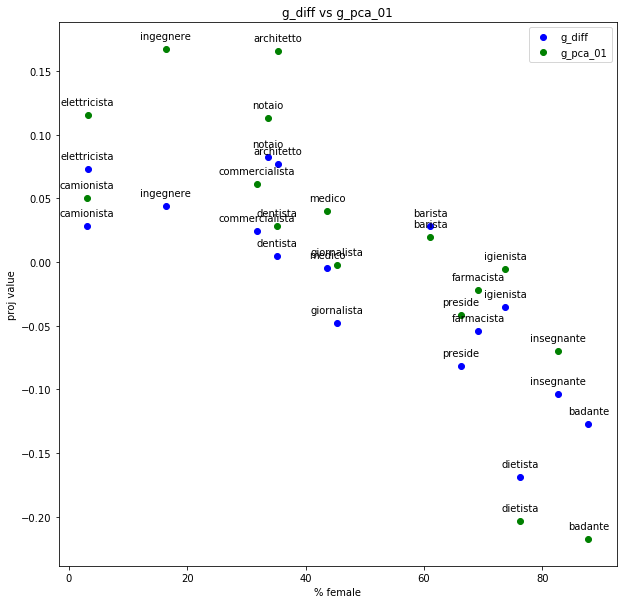

In [29]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_diff vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_g_diff_vs_g_pca_01')

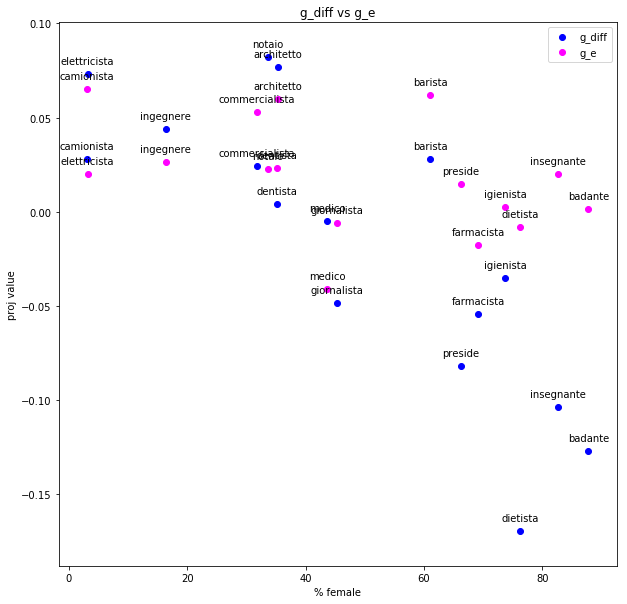

In [30]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_diff vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_g_diff_vs_g_e')

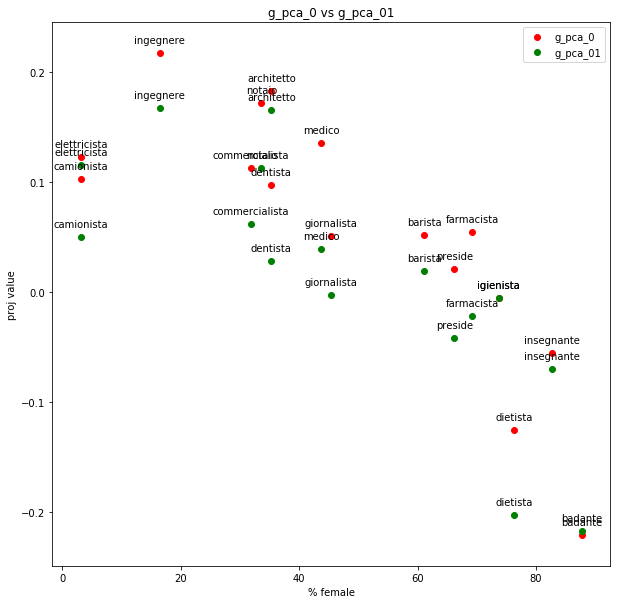

In [31]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_pca_0 vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_g_pca_0_vs_g_pca_01')

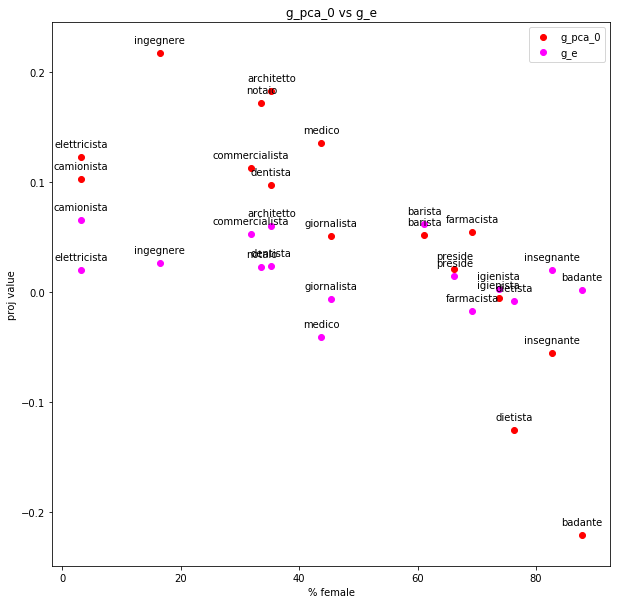

In [32]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_0 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_g_pca_0_vs_g_e')

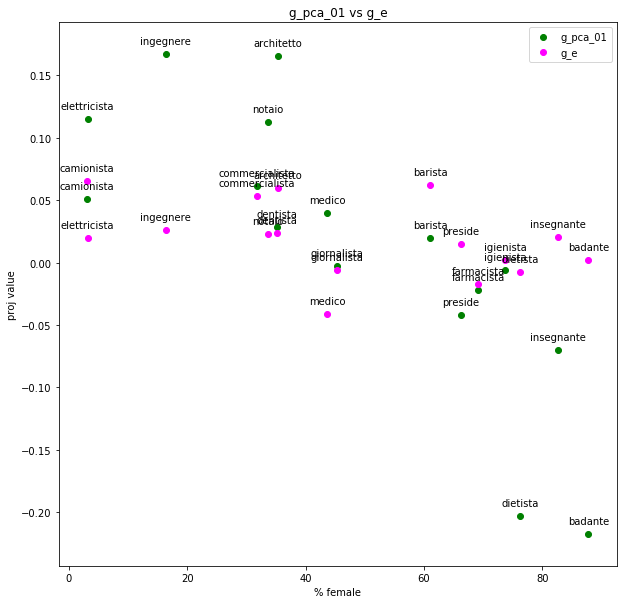

In [33]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_01 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_g_pca_01_vs_g_e')

##### Gendered professions

In [23]:
# read professions
prof_gen_truth = db.read('professions_gen.csv', 'truth-mf')

In [24]:
# compute projection of each profession on g_diff
proj_gen_g_diff = db.prof_proj(E_ft, prof_gen_truth, g_diff, 'istat-mf')

# compute projection of each profession on g_pca_0
proj_gen_g_pca_0 = db.prof_proj(E_ft, prof_gen_truth, g_pca_0, 'istat-mf')

# compute projection of each profession on g_pca_01
proj_gen_g_pca_01 = db.prof_proj(E_ft, prof_gen_truth, g_pca_01, 'istat-mf')

# compute projection of each profession on g_e
proj_gen_g_e = db.prof_proj(E_ft, prof_gen_truth, g_e, 'istat-mf')

In [25]:
# print results
gen_col0 = [] # pandas columns
gen_col1 = []
gen_col2 = []
gen_col3 = []
gen_col4 = []
gen_col5 = []
gen_col6 = []
gen_col7 = []
gen_col8 = []
gen_col9 = []
gen_col10 = []

for i in range(len(proj_gen_g_diff)):
    gen_col0.append(proj_gen_g_diff[i][0]) # male profession
    gen_col1.append(proj_gen_g_diff[i][1]) # male projection on g_diff
    gen_col2.append(proj_gen_g_pca_0[i][1]) # male projection on g_pca_0
    gen_col3.append(proj_gen_g_pca_01[i][1]) # male projection on g_pca_01
    gen_col4.append(np.real(proj_gen_g_e[i][1])) # male projection on g_e
    gen_col5.append(proj_gen_g_diff[i][2]) # female profession
    gen_col6.append(proj_gen_g_diff[i][3]) # female projection on g_diff
    gen_col7.append(proj_gen_g_pca_0[i][3]) # female projection on g_pca_0
    gen_col8.append(proj_gen_g_pca_01[i][3]) # female projection on g_pca_01
    gen_col9.append(np.real(proj_gen_g_e[i][3])) # female projection on g_e
    gen_col10.append(proj_gen_g_diff[i][4]) # %female
    
gen_data = {'Male profession':gen_col0, 
           'M-Proj g_diff':gen_col1,
           'M-Proj g_pca_0':gen_col2, 
           'M-Proj g_pca_01':gen_col3,
           'M-Prog g_e':gen_col4,
           'Female profession':gen_col5, 
           'F-Proj g_diff':gen_col6,
           'F-Proj g_pca_0':gen_col7, 
           'F-Proj g_pca_01':gen_col8,
           'F-Prog g_e':gen_col9,  
           '% female':gen_col10}

gen_table = pd.DataFrame(gen_data)
gen_table

,Male profession,M-Proj g_diff,M-Proj g_pca_0,M-Proj g_pca_01,M-Prog g_e,Female profession,F-Proj g_diff,F-Proj g_pca_0,F-Proj g_pca_01,F-Prog g_e,% female
0,calzolaio,0.106336,0.155676,0.117852,0.022520,calzolaia,-0.083221,-0.217826,-0.183558,-0.007811,8.0
1,biologo,0.066985,0.229635,0.178475,-0.050910,biologa,-0.263955,-0.272445,-0.288617,0.001746,76.0
2,avvocato,-0.053588,0.132720,0.056975,-0.010401,avvocatessa,-0.291315,-0.283173,-0.312245,0.060756,47.2
3,psicologo,0.068424,0.169177,0.117352,-0.015112,psicologa,-0.238524,-0.304119,-0.323389,0.005394,82.9
4,maestro,0.201372,0.312891,0.275900,0.023119,maestra,-0.244963,-0.301025,-0.313171,0.037129,96.4
5,professore,-0.029616,0.228402,0.129135,0.007852,professoressa,-0.323749,-0.292575,-0.333926,0.014332,71.9
6,cameriere,0.046219,0.097974,0.054632,0.046446,cameriera,-0.189663,-0.259899,-0.277246,0.015340,51.4
7,albergatore,0.081593,0.130638,0.134854,-0.004077,albergatrice,-0.200101,-0.274839,-0.248046,0.043339,50.6
8,infermiere,-0.044242,0.007298,-0.023620,0.044576,infermiera,-0.253701,-0.257126,-0.294478,0.042178,77.0
9,geologo,0.035964,0.187185,0.125979,-0.042255,geologa,-0.277250,-0.278603,-0.292457,0.024115,39.8


In [30]:
'''
m_g_diff = [el for el in gen_col1]
f_g_diff = [el for el in gen_col6]

m_g_pca = [el for el in gen_col2]
f_g_pca = [el for el in gen_col7]

avg_diff_g_diff = np.mean(np.array(m_g_diff)-np.array(f_g_diff))
avg_diff_g_pca = np.mean(np.array(m_g_pca)-np.array(f_g_pca))
w, p = scipy.stats.wilcoxon(np.array(m_g_diff)-np.array(f_g_diff))
'''

In [30]:
#gen_table.to_csv('truth_gen_ft.csv', index=False)

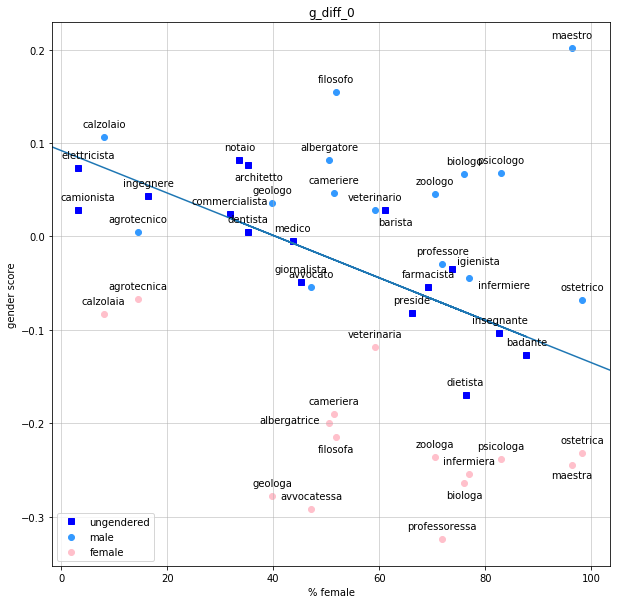

In [33]:
# correlation plot g_diff

# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col1, c='#3399ff', label='male')
ax.scatter(gen_col10, gen_col6, c='pink', label='female')
xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_diff_0')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend(loc='lower left')

for i, label in enumerate(ung_col0):
    if label=='elettricista' or label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='igienista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(27,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    

    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col0):
    if label=='infermiere':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(35,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    if label=='albergatrice':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-40,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='filosofa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue     
        
    if label=='biologa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue            
        
    if label=='maestra':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-13), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/gen/ft_g_diff.pdf', bbox_inches='tight', format='pdf')

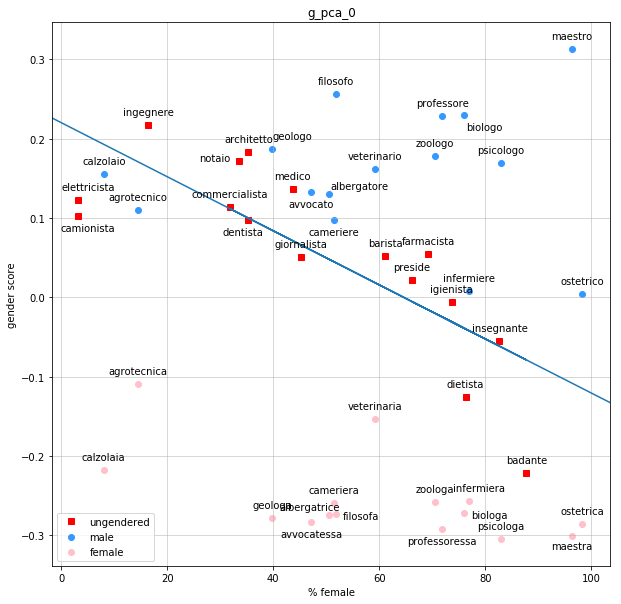

In [34]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col2, c='#3399ff', label='male')
ax.scatter(gen_col10, gen_col7, c='pink', label='female')
xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend(loc='lower left')

for i,label in enumerate(gen_col0):  
    if label=='geologo':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='albergatore':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    
        
    if label=='cameriere':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='avvocato':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  

    if label=='biologo':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    if label=='avvocatessa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='albergatrice':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='filosofa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='professoressa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
  
    if label=='biologa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
  
    if label=='infermiera':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='maestra':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-13), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ung_col0):
    if label=='elettricista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='notaio':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-25,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dentista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-5,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.show()
fig.savefig('plot/gen/ft_g_pca_0.pdf', bbox_inches='tight', format='pdf')

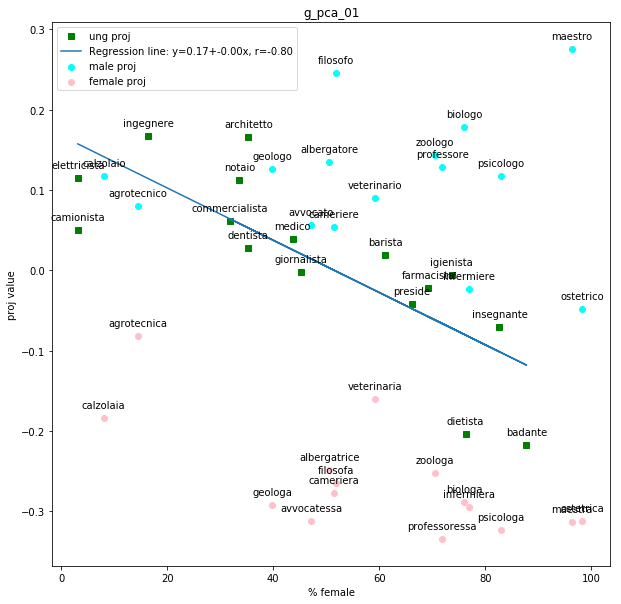

In [40]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col3, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col8, c='pink', label='female proj')
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col8[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/gen/ft_g_pca_01')

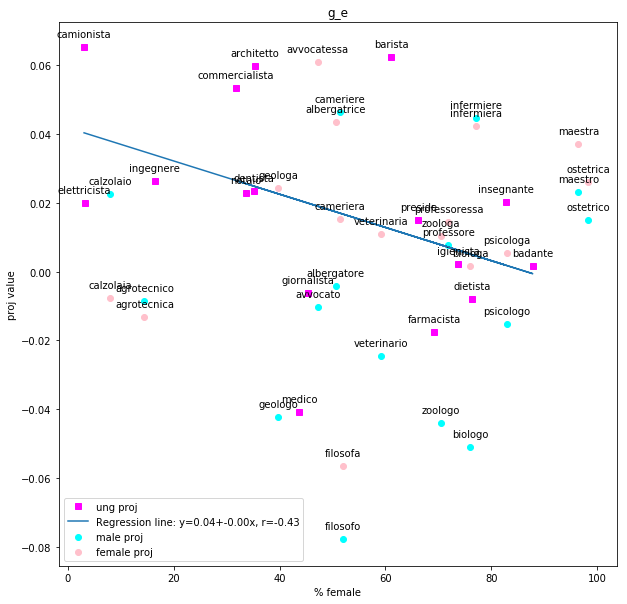

In [41]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col4, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col9, c='pink', label='female proj')
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col9[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/gen/ft_g_e')

##### Ungendered + mean gendered professions

In [35]:
# print mean results
mean_col0 = []
mean_col1 = []
mean_col2 = []
mean_col3 = []
mean_col4 = []
mean_col5 = []

for i in range(len(proj_ung_g_diff)):
    mean_col0.append(proj_ung_g_diff[i][0]) # profession
    mean_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    mean_col2.append(proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    mean_col3.append(proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    mean_col4.append(np.real(proj_ung_g_e[i][1])) # projection on g_e
    mean_col5.append(proj_ung_g_diff[i][3]) # %female
    
for i in range(len(proj_gen_g_diff)):
    mean_col0.append(proj_gen_g_diff[i][0]) # profession
    mean_col1.append((proj_gen_g_diff[i][1]+proj_gen_g_diff[i][3])/2) # mean projection on g_diff
    mean_col2.append((proj_gen_g_pca_0[i][1]+proj_gen_g_pca_0[i][3])/2) # mean projection on g_pca_0
    mean_col3.append((proj_gen_g_pca_01[i][1]+proj_gen_g_pca_01[i][3])/2) # mean projection on g_pca_01
    mean_col4.append((np.real(proj_gen_g_e[i][1])+np.real(proj_gen_g_e[i][3]))/2) # mean projection on g_e
    mean_col5.append(proj_gen_g_diff[i][4]) # %female
    
mean_data = {'Profession':mean_col0, 
           'Proj g_diff':mean_col1,
           'Proj g_pca_0':mean_col2, 
           'Proj g_pca_01':mean_col3,
           'Prog g_e':mean_col4, 
           '% female':mean_col5}

mean_table = pd.DataFrame(mean_data)
mean_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% female
0,camionista,0.027856,0.102896,0.050494,0.065189,3.1
1,elettricista,0.073085,0.122825,0.115196,0.019939,3.2
2,ingegnere,0.043748,0.217653,0.167188,0.026228,16.4
3,architetto,0.076696,0.183021,0.165500,0.059626,35.3
4,notaio,0.082010,0.171843,0.112616,0.022859,33.6
5,commercialista,0.024475,0.113249,0.061505,0.053153,31.8
6,giornalista,-0.048235,0.050688,-0.002423,-0.006167,45.3
7,insegnante,-0.103818,-0.055340,-0.070229,0.020056,82.7
8,barista,0.027839,0.052001,0.019284,0.062231,61.1
9,medico,-0.004724,0.135863,0.039559,-0.040868,43.7


In [36]:
# pearson correlation
r_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[0]
r_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[0]
r_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[0]
r_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[0]

p_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[1]
p_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[1]
p_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[1]
p_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[1]

In [37]:
pearson_data = {'g_diff':[r_mean_g_diff,p_mean_g_diff],
                'g_pca_0':[r_mean_g_pca_0,p_mean_g_pca_0],
                'g_pca_01':[r_mean_g_pca_01,p_mean_g_pca_01],
                'g_e':[r_mean_g_e,p_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.663815,-0.633884,-0.671989,-0.191416
p,0.000047,0.000129,0.000035,0.302289


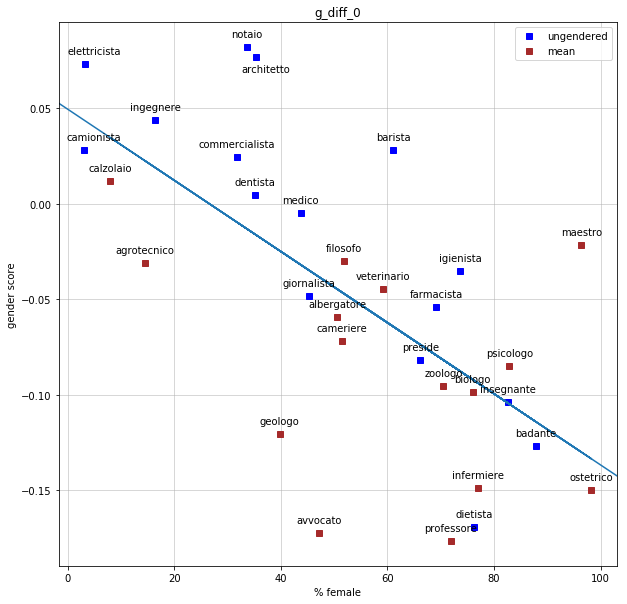

In [38]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(mean_col5[:16], mean_col1[:16], linewidth=0, marker='s', color='blue', label='ungendered')
ax.plot(mean_col5[16:], mean_col1[16:], linewidth=0, marker='s', color='brown', label='mean')
#ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)

ax.set_title('g_diff_0')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend()

for i, label in enumerate(mean_col0):
    if label=='elettricista' or label=='camionista':
        plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/ft_g_diff.pdf', bbox_inches='tight', format='pdf')

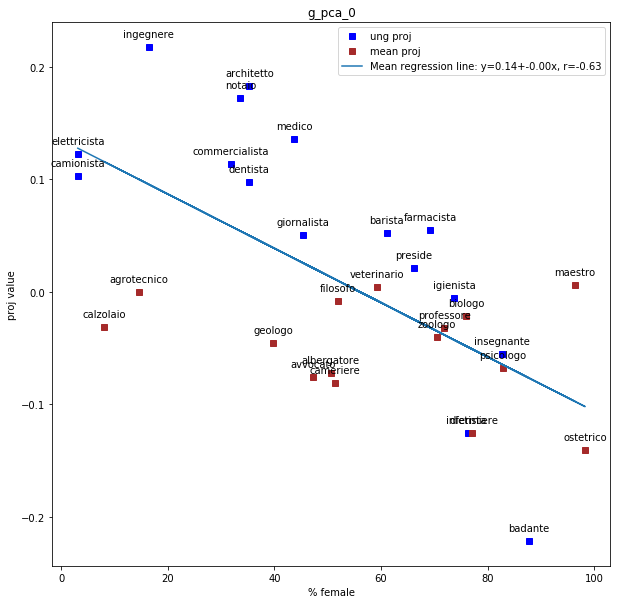

In [59]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col2)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col2[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col2[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/ft_g_pca_0')

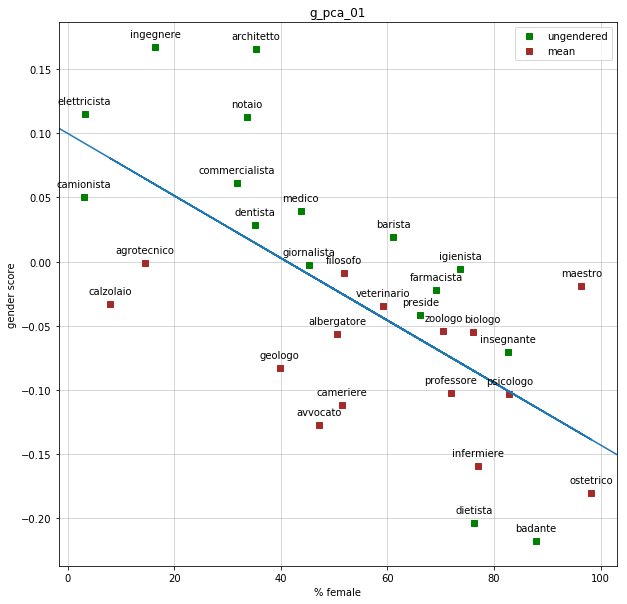

In [39]:
# scatter plots

slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col3)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(mean_col5[:16], mean_col3[:16], linewidth=0, marker='s', color='green', label='ungendered')
ax.plot(mean_col5[16:], mean_col3[16:], linewidth=0, marker='s', color='brown', label='mean')
#ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend()

for i, label in enumerate(mean_col0):
    if label=='biologo':
        plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/ft_g_pca_01.pdf', bbox_inches='tight', format='pdf')

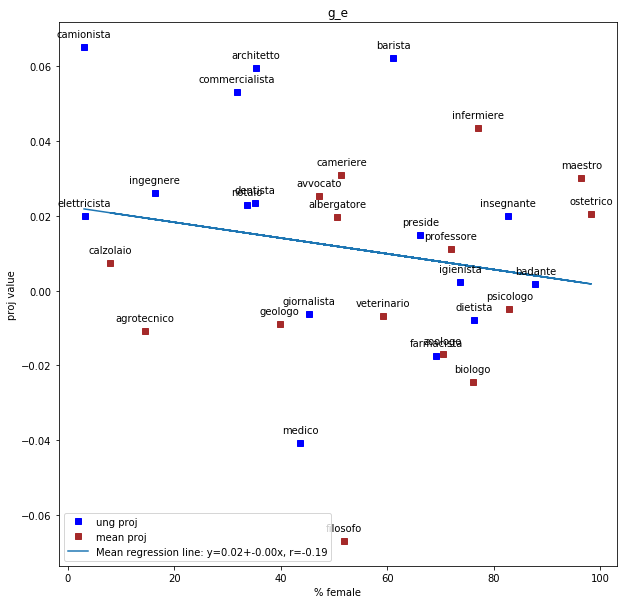

In [61]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col4)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col4[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col4[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/ft_g_e')

#### Step 2.5: subtracting grammatical gender to the emdeddings

In [40]:
from debiaswe.debias import debias

In [41]:
debias(E_ft, [], G_word, [])

485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica
set()
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica


#### Step 2.6: repeating Steps 2.1-2.4

In [42]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

In [43]:
# list of pairs to define gender
'''
gender_pairs = [['lei','lui'],
                ['donna','uomo'], 
                ['madre','padre'],
                ['moglie','marito'],
                ['sorella','fratello'],
                ['femmina','maschio']]
'''

gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [44]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [45]:
print("Singular values:")
print(sv)

Singular values:
[6.9684738e-01 5.0248235e-01 3.8360339e-01 3.4403831e-01 3.0402446e-01
 2.4636908e-01 6.0329249e-08 4.8515240e-08 4.6014925e-08 3.9377852e-08]


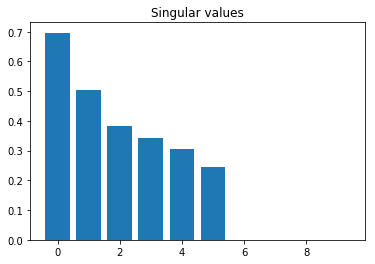

In [46]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [47]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [48]:
'''
S_word = [['lei','lui'],
          ['donna','uomo'],
          ['madre','padre'],
          ['moglie','marito'],
          ['sorella','fratello'],
          ['femmina','maschio']]
'''

S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [49]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [50]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [51]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

##### Ungendered professions

In [52]:
# read professions
prof_ung_truth = db.read('professions_ung.csv', 'truth')

In [53]:
# compute projection of each profession on g_diff
proj_ung_g_diff = db.prof_proj(E_ft, prof_ung_truth, g_diff, 'istat')

# compute projection of each profession on g_pca_0
proj_ung_g_pca_0 = db.prof_proj(E_ft, prof_ung_truth, g_pca_0, 'istat')

# compute projection of each profession on g_pca_01
proj_ung_g_pca_01 = db.prof_proj(E_ft, prof_ung_truth, g_pca_01, 'istat')

# compute projection of each profession on g_e
proj_ung_g_e = db.prof_proj(E_ft, prof_ung_truth, g_e, 'istat')

In [54]:
# print results
ung_col0 = [] # pandas columns
ung_col1 = []
ung_col2 = []
ung_col3 = []
ung_col4 = []
ung_col5 = []
ung_col6 = []

for i in range(len(proj_ung_g_diff)):
    ung_col0.append(proj_ung_g_diff[i][0]) # profession
    ung_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    ung_col2.append(proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    ung_col3.append(proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    ung_col4.append(np.real(proj_ung_g_e[i][1])) # projection on g_e
    ung_col5.append(proj_ung_g_diff[i][2]) # %male
    ung_col6.append(proj_ung_g_diff[i][3]) # %female

    
ung_data = {'Profession':ung_col0, 
           'Proj g_diff':ung_col1,
           'Proj g_pca_0':ung_col2, 
           'Proj g_pca_01':ung_col3,
           'Prog g_e':ung_col4,
           '% male':ung_col5, 
           '% female':ung_col6}
ung_table = pd.DataFrame(ung_data)
ung_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% male,% female
0,camionista,0.000958,0.010437,0.057523,-0.028762,96.9,3.1
1,elettricista,0.051165,0.075229,0.060888,0.006139,96.8,3.2
2,ingegnere,0.006015,0.132715,0.159754,0.003354,83.6,16.4
3,architetto,0.048271,0.128841,0.118354,0.017533,64.7,35.3
4,notaio,0.047991,0.074732,0.122838,0.140066,66.4,33.6
5,commercialista,-0.001897,0.031570,0.078392,0.078729,68.2,31.8
6,giornalista,-0.066798,-0.020748,0.039422,0.051914,54.7,45.3
7,insegnante,-0.099758,-0.070729,-0.047352,0.048904,17.3,82.7
8,barista,0.017341,0.004999,0.040029,-0.046712,38.9,61.1
9,medico,-0.053320,-0.038994,0.043721,-0.014985,56.3,43.7


In [55]:
#ung_table.to_csv('truth_ung_ft_deb.csv', index=False)

In [56]:
# pearson correlation
r_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[0]
r_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[0]
r_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[0]
r_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[0]

p_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[1]
p_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[1]
p_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[1]
p_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[1]

In [57]:
pearson_data = {'g_diff':[r_g_diff,p_g_diff],
                'g_pca_0':[r_g_pca_0,p_g_pca_0],
                'g_pca_01':[r_g_pca_01,p_g_pca_01],
                'g_e':[r_g_e,p_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.736332,-0.734737,-0.747096,0.068338
p,0.001143,0.001187,0.000881,0.801449


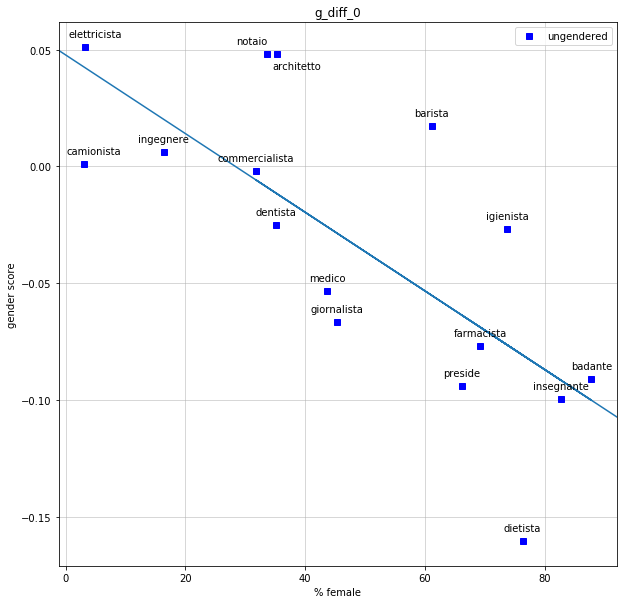

In [58]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend()

for i, label in enumerate(ung_col0):
    if label=='elettricista' or label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='notaio':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-15,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/ft_deb_g_diff.pdf', bbox_inches='tight', format='pdf')

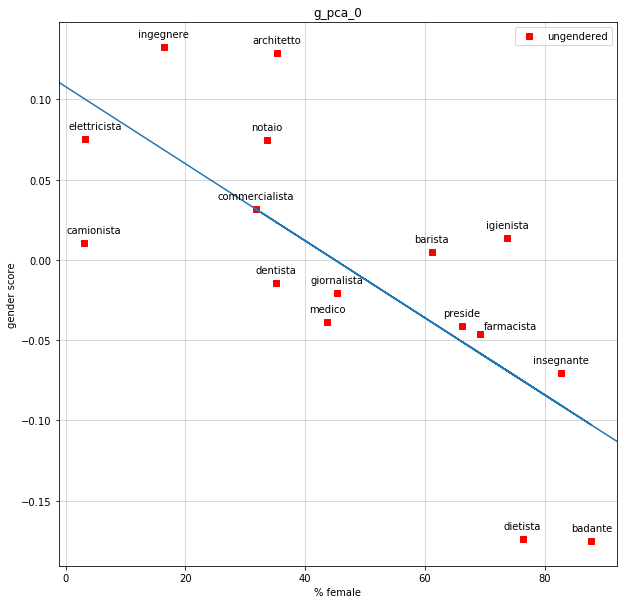

In [59]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.set_title("g_pca_0")
ax.legend()

for i, label in enumerate(ung_col0):
    if label=='elettricista' or label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='farmacista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/ft_deb_g_pca_0.pdf', bbox_inches='tight', format='pdf')

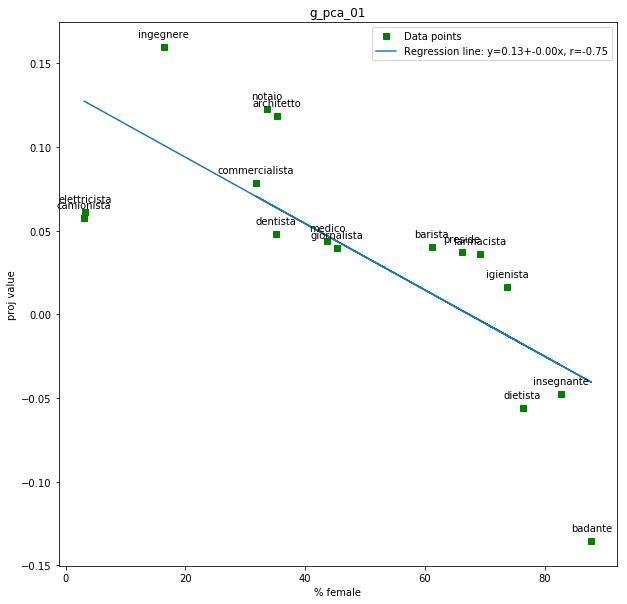

In [36]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")

ax.legend(facecolor='white')
for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/ft_deb_g_pca_01')

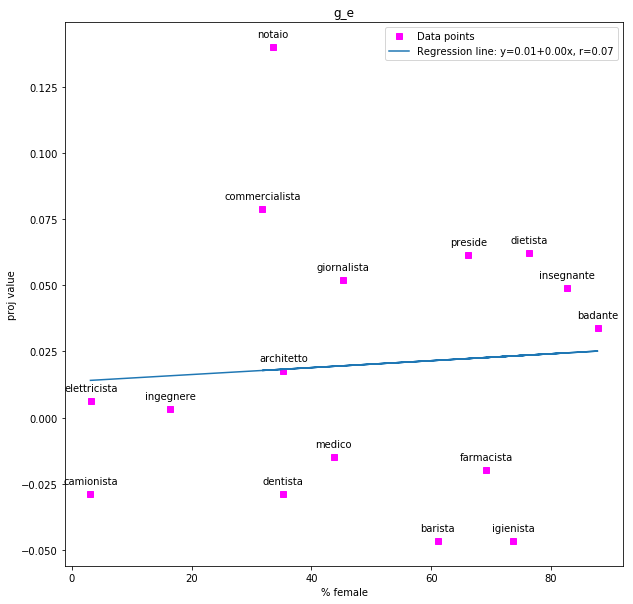

In [37]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/ft_deb_g_e')

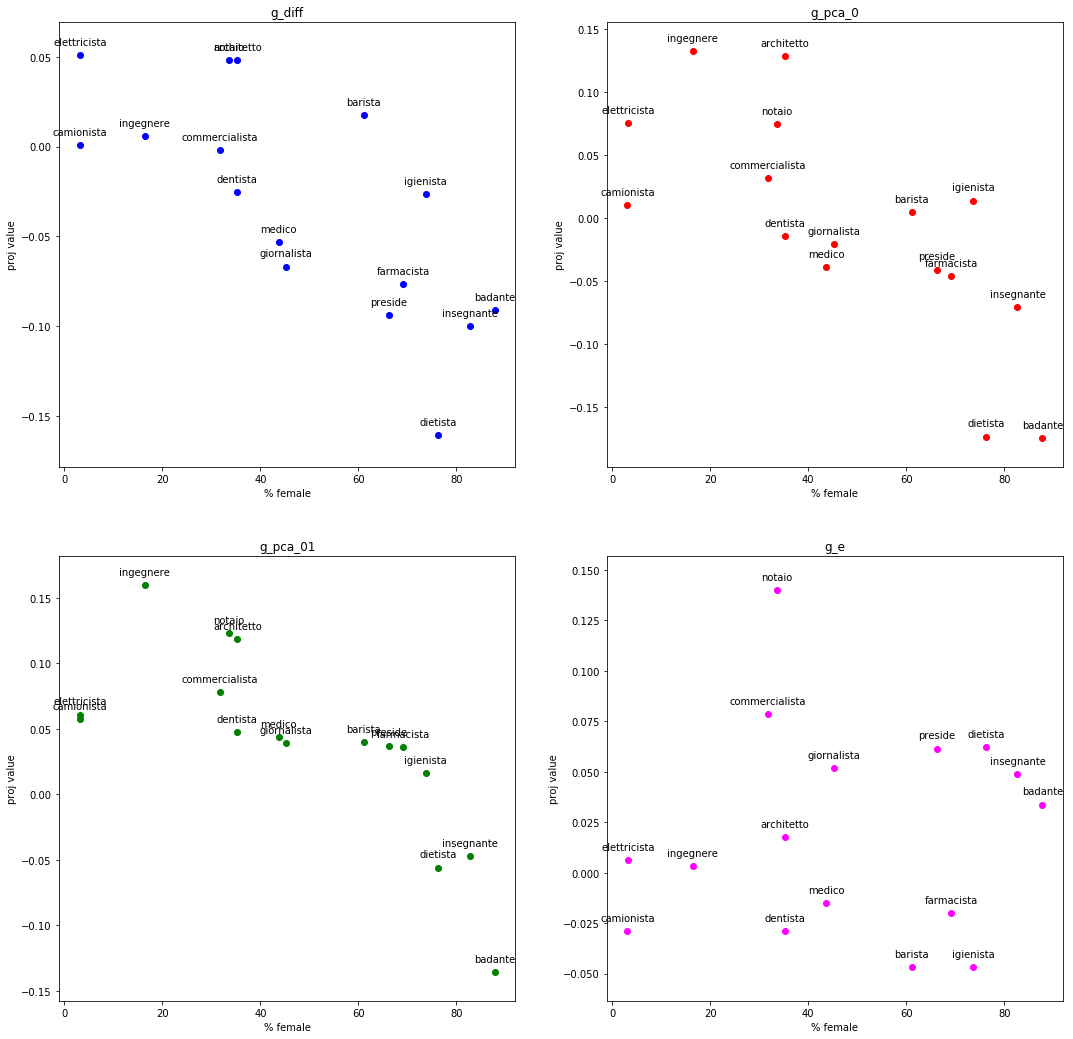

In [38]:
# scatter plots

plt.figure(figsize=(18,18))    

ax1 = plt.subplot(221)
ax1.scatter(ung_col6, ung_col1, c='blue')
ax1.set_title('g_diff')
ax1.set_xlabel('% female')
ax1.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax2 = plt.subplot(222)
ax2.scatter(ung_col6, ung_col2, c='red')
ax2.set_title('g_pca_0')
ax2.set_xlabel('% female')
ax2.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax3 = plt.subplot(223)
ax3.scatter(ung_col6, ung_col3, c='green')
ax3.set_title('g_pca_01')
ax3.set_xlabel('% female')
ax3.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
ax4 = plt.subplot(224)
ax4.scatter(ung_col6, ung_col4, c='magenta')
ax4.set_title('g_e')
ax4.set_xlabel('% female')
ax4.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()
fig.savefig('plot/ung/scatter/ft_deb_all')

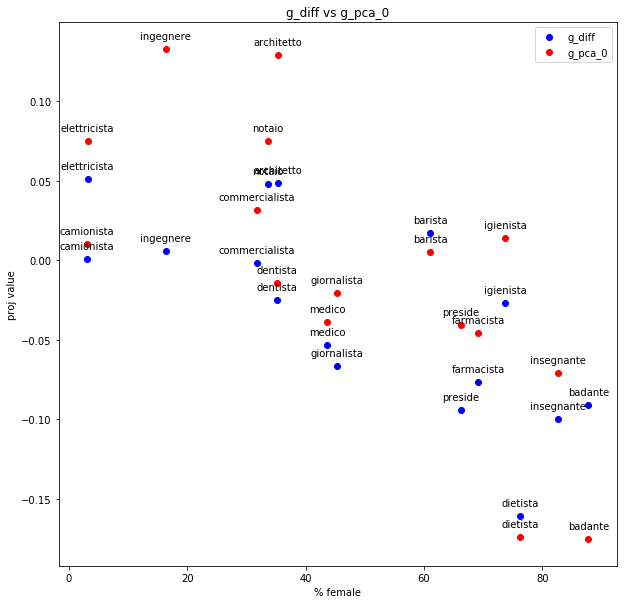

In [39]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.set_title('g_diff vs g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_deb_g_diff_vs_g_pca_0')

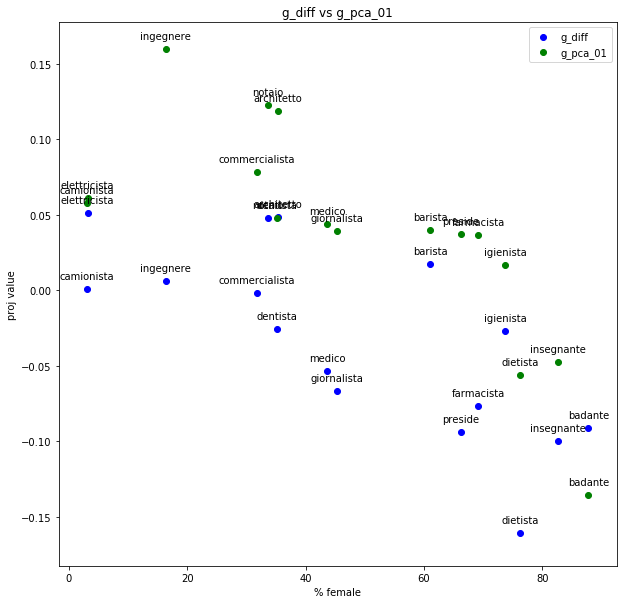

In [40]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_diff vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_deb_g_diff_vs_g_pca_01')

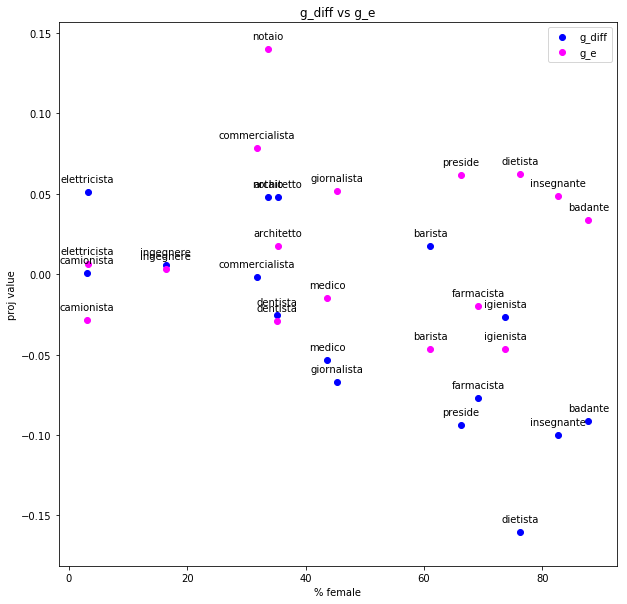

In [41]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_diff vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_deb_g_diff_vs_g_e')

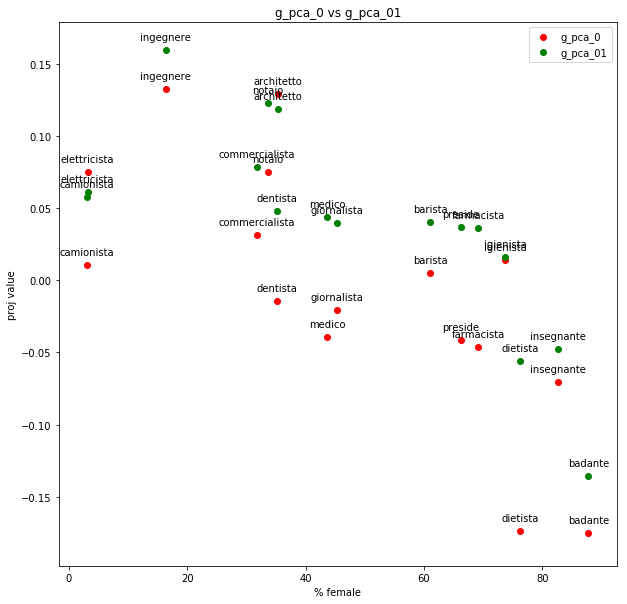

In [42]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_pca_0 vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_deb_g_pca_0_vs_g_pca_01')

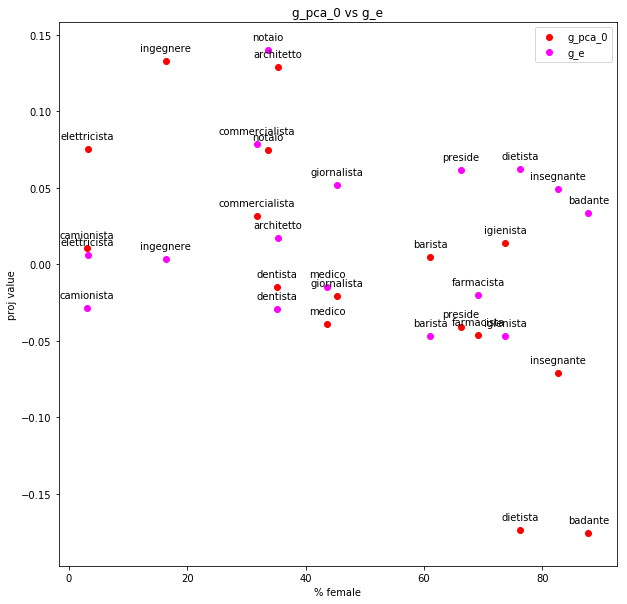

In [43]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_0 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_deb_g_pca_0_vs_g_e')

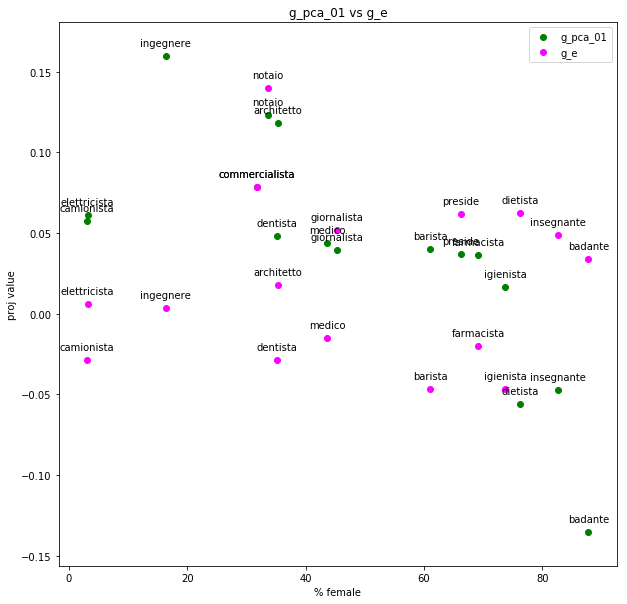

In [44]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_01 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/ft_deb_g_pca_01_vs_g_e')

##### Gendered professions

In [60]:
# read professions
prof_gen_truth = db.read('professions_gen.csv', 'truth-mf')

In [61]:
# compute projection of each profession on g_diff
proj_gen_g_diff = db.prof_proj(E_ft, prof_gen_truth, g_diff, 'istat-mf')

# compute projection of each profession on g_pca_0
proj_gen_g_pca_0 = db.prof_proj(E_ft, prof_gen_truth, g_pca_0, 'istat-mf')

# compute projection of each profession on g_pca_01
proj_gen_g_pca_01 = db.prof_proj(E_ft, prof_gen_truth, g_pca_01, 'istat-mf')

# compute projection of each profession on g_e
proj_gen_g_e = db.prof_proj(E_ft, prof_gen_truth, g_e, 'istat-mf')

In [62]:
# print results
gen_col0 = [] # pandas columns
gen_col1 = []
gen_col2 = []
gen_col3 = []
gen_col4 = []
gen_col5 = []
gen_col6 = []
gen_col7 = []
gen_col8 = []
gen_col9 = []
gen_col10 = []

for i in range(len(proj_gen_g_diff)):
    gen_col0.append(proj_gen_g_diff[i][0]) # male profession
    gen_col1.append(proj_gen_g_diff[i][1]) # male projection on g_diff
    gen_col2.append(proj_gen_g_pca_0[i][1]) # male projection on g_pca_0
    gen_col3.append(proj_gen_g_pca_01[i][1]) # male projection on g_pca_01
    gen_col4.append(np.real(proj_gen_g_e[i][1])) # male projection on g_e
    gen_col5.append(proj_gen_g_diff[i][2]) # female profession
    gen_col6.append(proj_gen_g_diff[i][3]) # female projection on g_diff
    gen_col7.append(proj_gen_g_pca_0[i][3]) # female projection on g_pca_0
    gen_col8.append(proj_gen_g_pca_01[i][3]) # female projection on g_pca_01
    gen_col9.append(np.real(proj_gen_g_e[i][3])) # female projection on g_e
    gen_col10.append(proj_gen_g_diff[i][4]) # %female
    
gen_data = {'Male profession':gen_col0, 
           'M-Proj g_diff':gen_col1,
           'M-Proj g_pca_0':gen_col2, 
           'M-Proj g_pca_01':gen_col3,
           'M-Prog g_e':gen_col4,
           'Female profession':gen_col5, 
           'F-Proj g_diff':gen_col6,
           'F-Proj g_pca_0':gen_col7, 
           'F-Proj g_pca_01':gen_col8,
           'F-Prog g_e':gen_col9,  
           '% female':gen_col10}

gen_table = pd.DataFrame(gen_data)
gen_table

,Male profession,M-Proj g_diff,M-Proj g_pca_0,M-Proj g_pca_01,M-Prog g_e,Female profession,F-Proj g_diff,F-Proj g_pca_0,F-Proj g_pca_01,F-Prog g_e,% female
0,calzolaio,0.079271,0.081505,0.105640,-0.049912,calzolaia,-0.014804,-0.044504,-0.012927,-0.040669,8.0
1,biologo,0.015788,0.103029,0.119144,0.073356,biologa,-0.223442,-0.215060,-0.141161,-0.045970,76.0
2,avvocato,-0.086206,0.030805,0.101467,0.096192,avvocatessa,-0.244240,-0.206941,-0.103990,0.016933,47.2
3,psicologo,0.025581,0.041972,0.066970,0.056083,psicologa,-0.192896,-0.249648,-0.163175,0.034717,82.9
4,maestro,0.159218,0.235579,0.239014,0.040721,maestra,-0.189827,-0.201996,-0.114366,0.040153,96.4
5,professore,-0.084330,0.078977,0.159987,0.081700,professoressa,-0.284365,-0.249782,-0.137540,0.030730,71.9
6,cameriere,0.007340,-0.034930,-0.014165,-0.006508,cameriera,-0.143171,-0.192962,-0.110693,-0.009995,51.4
7,albergatore,0.057318,0.080634,0.044936,0.017233,albergatrice,-0.144356,-0.151718,-0.122668,0.033562,50.6
8,infermiere,-0.072265,-0.109098,-0.097028,-0.033959,infermiera,-0.214588,-0.219005,-0.119956,-0.012385,77.0
9,geologo,-0.000254,0.097662,0.148690,0.026921,geologa,-0.233198,-0.201702,-0.121670,-0.004921,39.8


In [63]:
#gen_table.to_csv('truth_gen_ft_deb.csv', index=False)

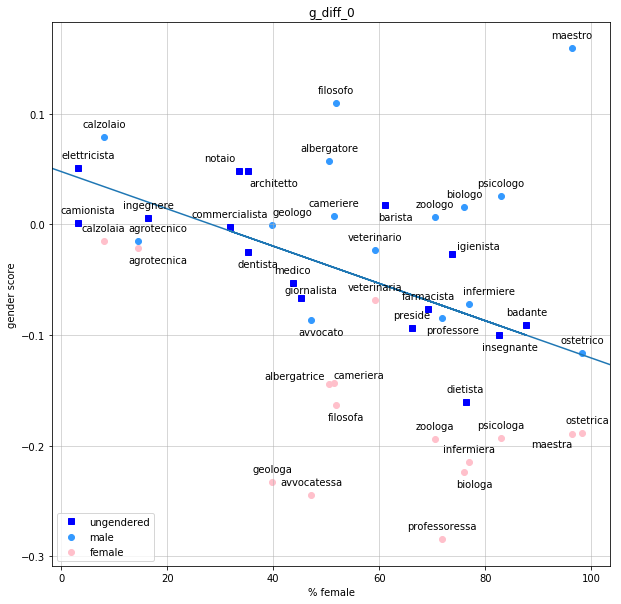

In [64]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col1, c='#3399ff', label='male')
ax.scatter(gen_col10, gen_col6, c='pink', label='female')
xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_diff_0')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend(loc='lower left')

for i, label in enumerate(ung_col0):
    if label=='elettricista' or label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='notaio':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dentista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='igienista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(27,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue   
        
    if label=='giornalista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='insegnante':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col0):
    if label=='agrotecnico':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='geologo':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='avvocato':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='professore':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='infermiere':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


for i,label in enumerate(gen_col5):
    if label=='agrotecnica':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='filosofa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='albergatrice':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-35,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='cameriera':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='biologa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    
        
    if label=='maestra':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,-13), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='ostetrica':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(5,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/gen/ft_deb_g_diff.pdf', bbox_inches='tight', format='pdf')

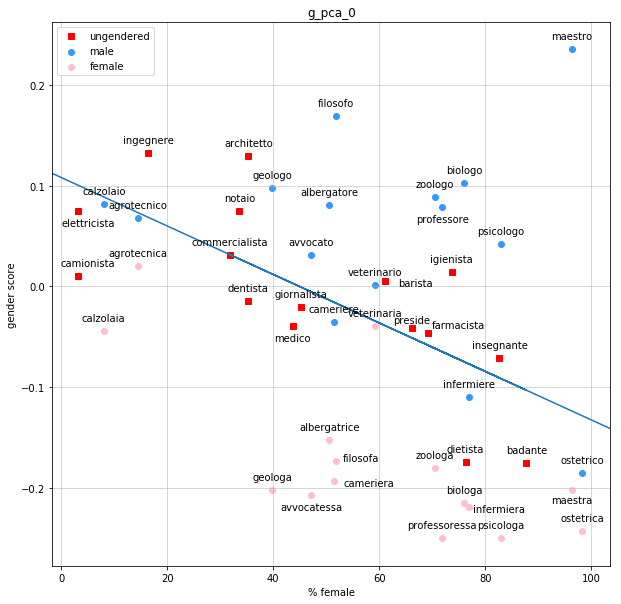

In [65]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col2, c='#3399ff', label='male')
ax.scatter(gen_col10, gen_col7, c='pink', label='female')
xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend()

for i,label in enumerate(gen_col0):
    if label=='professore':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    if label=='avvocatessa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='cameriera':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(35,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='filosofa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='infermiera':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='maestra':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-13), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ung_col0):
    if label=='elettricista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='medico':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='farmacista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='preside':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.show()
fig.savefig('plot/gen/ft_deb_g_pca_0.pdf', bbox_inches='tight', format='pdf')

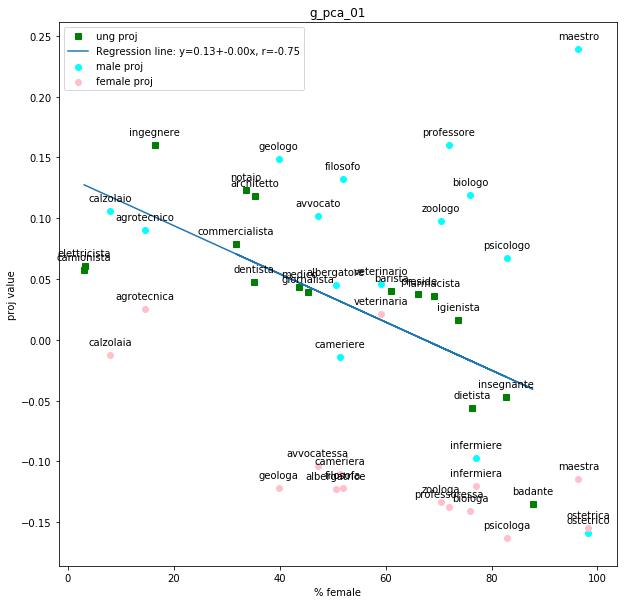

In [51]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col3, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col8, c='pink', label='female proj')
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col8[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/gen/ft_deb_g_pca_01')

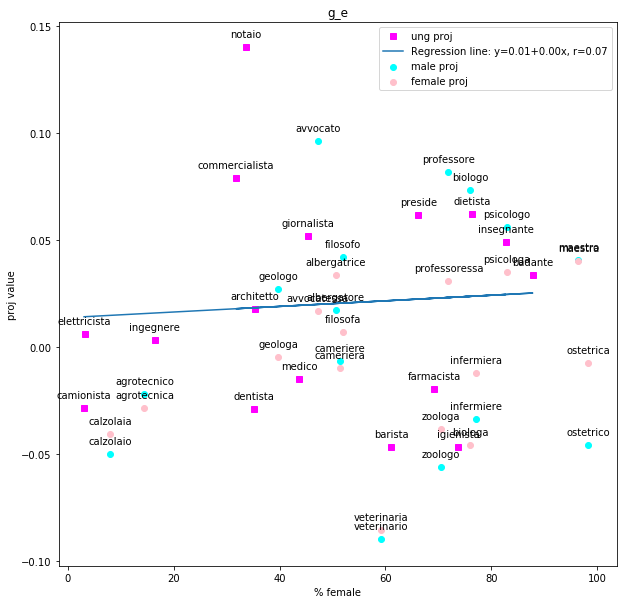

In [52]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col4, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col9, c='pink', label='female proj')
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col9[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/gen/ft_deb_g_e')

##### Ungendered + mean gendered professions

In [66]:
# print mean results
mean_col0 = []
mean_col1 = []
mean_col2 = []
mean_col3 = []
mean_col4 = []
mean_col5 = []

for i in range(len(proj_ung_g_diff)):
    mean_col0.append(proj_ung_g_diff[i][0]) # profession
    mean_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    mean_col2.append(proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    mean_col3.append(proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    mean_col4.append(np.real(proj_ung_g_e[i][1])) # projection on g_e
    mean_col5.append(proj_ung_g_diff[i][3]) # %female
    
for i in range(len(proj_gen_g_diff)):
    mean_col0.append(proj_gen_g_diff[i][0]) # profession
    mean_col1.append((proj_gen_g_diff[i][1]+proj_gen_g_diff[i][3])/2) # mean projection on g_diff
    mean_col2.append((proj_gen_g_pca_0[i][1]+proj_gen_g_pca_0[i][3])/2) # mean projection on g_pca_0
    mean_col3.append((proj_gen_g_pca_01[i][1]+proj_gen_g_pca_01[i][3])/2) # mean projection on g_pca_01
    mean_col4.append((np.real(proj_gen_g_e[i][1])+np.real(proj_gen_g_e[i][3]))/2) # mean projection on g_e
    mean_col5.append(proj_gen_g_diff[i][4]) # %female
    
mean_data = {'Profession':mean_col0, 
           'Proj g_diff':mean_col1,
           'Proj g_pca_0':mean_col2, 
           'Proj g_pca_01':mean_col3,
           'Prog g_e':mean_col4, 
           '% female':mean_col5}

mean_table = pd.DataFrame(mean_data)
mean_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% female
0,camionista,0.000958,0.010437,0.057523,-0.028762,3.1
1,elettricista,0.051165,0.075229,0.060888,0.006139,3.2
2,ingegnere,0.006015,0.132715,0.159754,0.003354,16.4
3,architetto,0.048271,0.128841,0.118354,0.017533,35.3
4,notaio,0.047991,0.074732,0.122838,0.140066,33.6
5,commercialista,-0.001897,0.031570,0.078392,0.078729,31.8
6,giornalista,-0.066798,-0.020748,0.039422,0.051914,45.3
7,insegnante,-0.099758,-0.070729,-0.047352,0.048904,82.7
8,barista,0.017341,0.004999,0.040029,-0.046712,61.1
9,medico,-0.053320,-0.038994,0.043721,-0.014985,43.7


In [67]:
# pearson correlation
r_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[0]
r_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[0]
r_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[0]
r_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[0]

p_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[1]
p_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[1]
p_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[1]
p_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[1]

In [68]:
pearson_data = {'g_diff':[r_mean_g_diff,p_mean_g_diff],
                'g_pca_0':[r_mean_g_pca_0,p_mean_g_pca_0],
                'g_pca_01':[r_mean_g_pca_01,p_mean_g_pca_01],
                'g_e':[r_mean_g_e,p_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.637091,-0.684213,-0.663947,0.088493
p,0.000116,0.000022,0.000047,0.635933


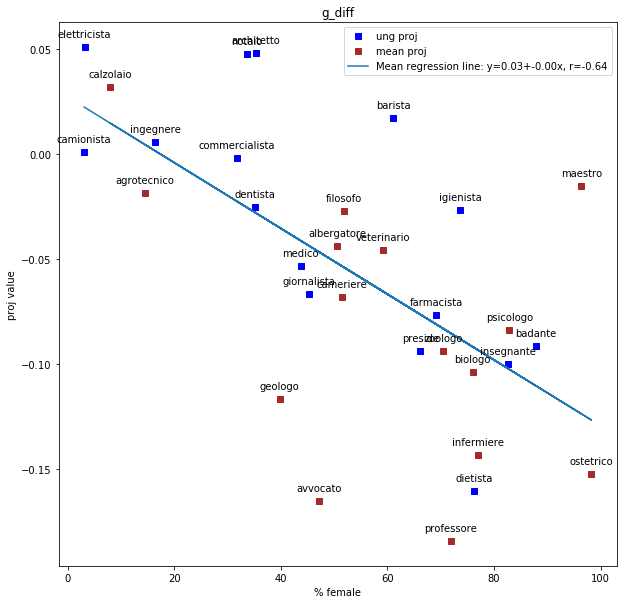

In [56]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col1[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col1[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_diff')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/ft_deb_g_diff')

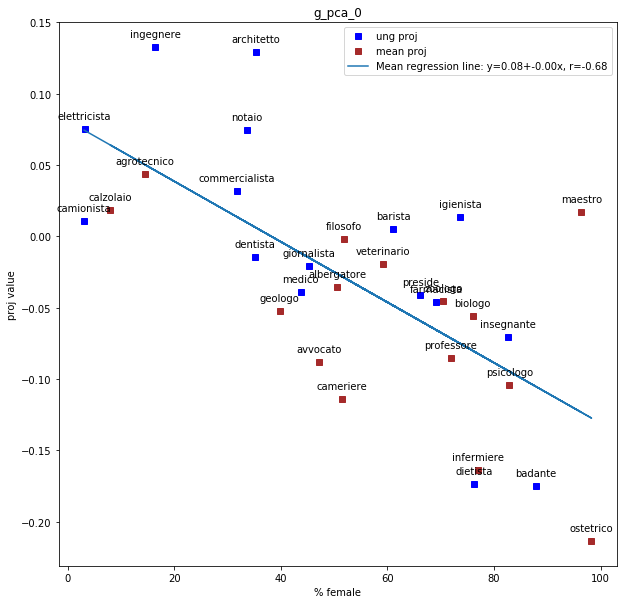

In [57]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col2)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col2[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col2[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/ft_deb_g_pca_0')

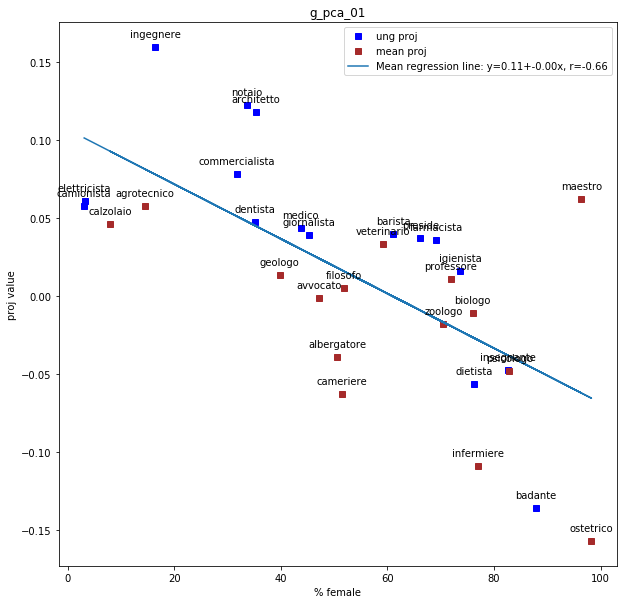

In [58]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col3)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col3[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col3[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/ft_deb_g_pca_01')

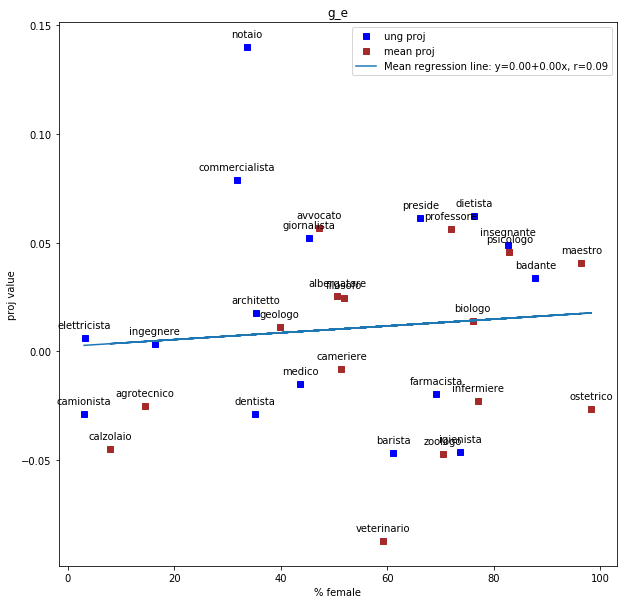

In [59]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col4)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col4[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col4[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/ft_deb_g_e')

### Step 3: working with Gonen's embeddings

#### Step 3.1: repeating steps 2.1-2.5

In [60]:
# gender direction
g_diff = E_g.diff('lui', 'lei')

In [61]:
# list of pairs to define gender
'''
gender_pairs = [['lei','lui'],
                ['donna','uomo'], 
                ['madre','padre'],
                ['moglie','marito'],
                ['sorella','fratello'],
                ['femmina','maschio']]
'''

gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [62]:
# PCA
pca = we.doPCA(gender_pairs, E_g)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [63]:
print("Singular values:")
print(sv)

Singular values:
[6.73165823e-01 4.74985087e-01 4.38029897e-01 3.35332203e-01
 2.90767211e-01 2.36732569e-01 1.27794811e-16 1.13799029e-16
 9.10948385e-17 8.73430101e-17]


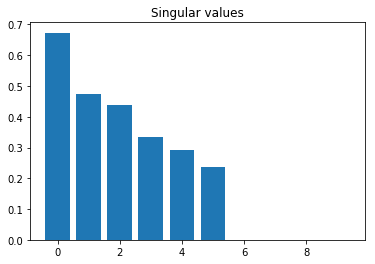

In [64]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [65]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [66]:
'''
S_word = [['lei','lui'],
          ['donna','uomo'],
          ['madre','padre'],
          ['moglie','marito'],
          ['sorella','fratello'],
          ['femmina','maschio']]
'''

S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [67]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_g.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_g.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_g.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_g.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [68]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [69]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

##### Ungendered professions

In [70]:
# read professions
prof_ung_truth = db.read('professions_ung.csv', 'truth')

In [71]:
# compute projection of each profession on g_diff
proj_ung_g_diff = db.prof_proj(E_g, prof_ung_truth, g_diff, 'istat')

# compute projection of each profession on g_pca_0
proj_ung_g_pca_0 = db.prof_proj(E_g, prof_ung_truth, g_pca_0, 'istat')

# compute projection of each profession on g_pca_01
proj_ung_g_pca_01 = db.prof_proj(E_g, prof_ung_truth, g_pca_01, 'istat')

# compute projection of each profession on g_e
proj_ung_g_e = db.prof_proj(E_g, prof_ung_truth, g_e, 'istat')

In [72]:
# print results
ung_col0 = [] # pandas columns
ung_col1 = []
ung_col2 = []
ung_col3 = []
ung_col4 = []
ung_col5 = []
ung_col6 = []

for i in range(len(proj_ung_g_diff)):
    ung_col0.append(proj_ung_g_diff[i][0]) # profession
    ung_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    ung_col2.append(-proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    ung_col3.append(-proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    ung_col4.append(-np.real(proj_ung_g_e[i][1])) # projection on g_e
    ung_col5.append(proj_ung_g_diff[i][2]) # %male
    ung_col6.append(proj_ung_g_diff[i][3]) # %female

    
ung_data = {'Profession':ung_col0, 
           'Proj g_diff':ung_col1,
           'Proj g_pca_0':ung_col2, 
           'Proj g_pca_01':ung_col3,
           'Prog g_e':ung_col4,
           '% male':ung_col5, 
           '% female':ung_col6}
ung_table = pd.DataFrame(ung_data)
ung_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% male,% female
0,camionista,-0.116571,-0.065065,-0.090247,-0.021633,96.9,3.1
1,elettricista,-0.032968,0.039751,0.006391,0.036579,96.8,3.2
2,ingegnere,0.048153,0.174863,0.120834,0.060551,83.6,16.4
3,architetto,0.094760,0.186434,0.117584,0.024187,64.7,35.3
4,notaio,0.045788,0.054650,-0.022539,-0.051675,66.4,33.6
5,commercialista,-0.058101,0.046732,-0.014279,-0.005193,68.2,31.8
6,giornalista,-0.111980,-0.057983,-0.094459,-0.029385,54.7,45.3
7,insegnante,-0.157774,-0.082164,-0.162323,0.007874,17.3,82.7
8,barista,-0.187549,-0.134068,-0.184296,-0.017124,38.9,61.1
9,medico,0.011663,0.018053,-0.062328,0.027769,56.3,43.7


In [73]:
ung_table.to_csv('truth_ung_g.csv', index=False)

In [74]:
# pearson correlation
r_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[0]
r_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[0]
r_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[0]
r_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[0]

p_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[1]
p_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[1]
p_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[1]
p_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[1]

In [75]:
pearson_data = {'g_diff':[r_g_diff,p_g_diff],
                'g_pca_0':[r_g_pca_0,p_g_pca_0],
                'g_pca_01':[r_g_pca_01,p_g_pca_01],
                'g_e':[r_g_e,p_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.418451,-0.532402,-0.598369,-0.138272
p,0.120590,0.041041,0.018449,0.623117


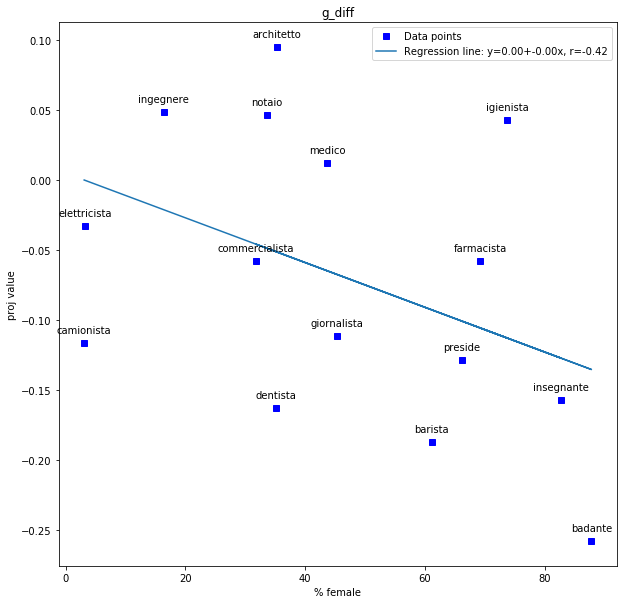

In [76]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/g_g_diff')

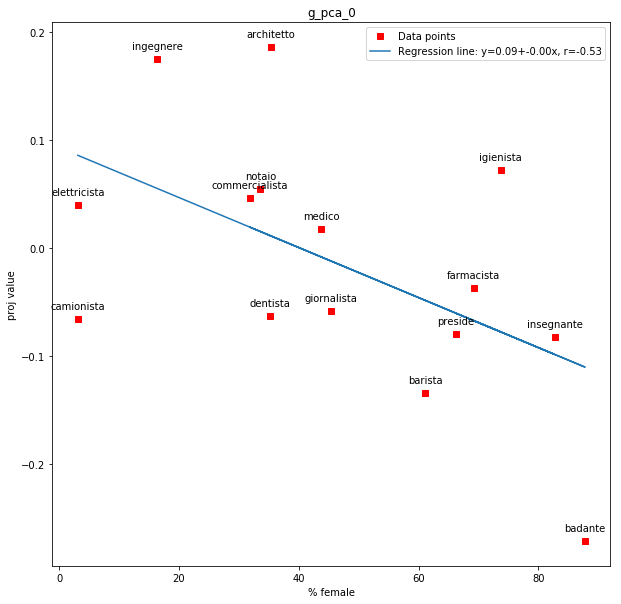

In [77]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/g_g_pca_0')

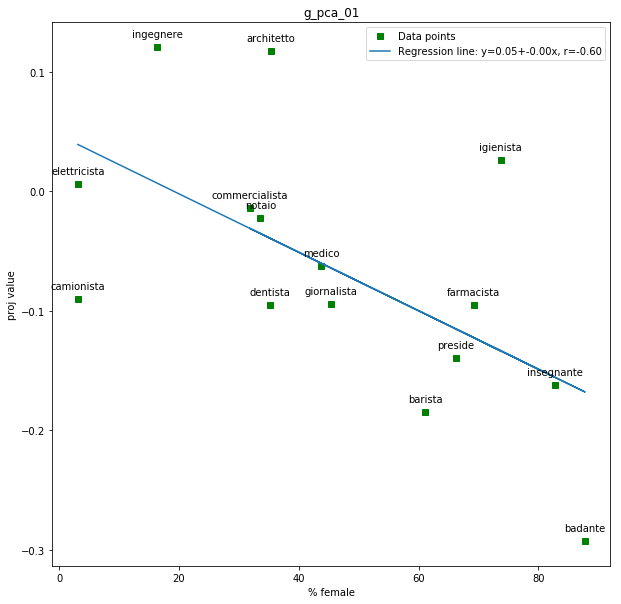

In [78]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")

ax.legend(facecolor='white')
for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/g_g_pca_01')

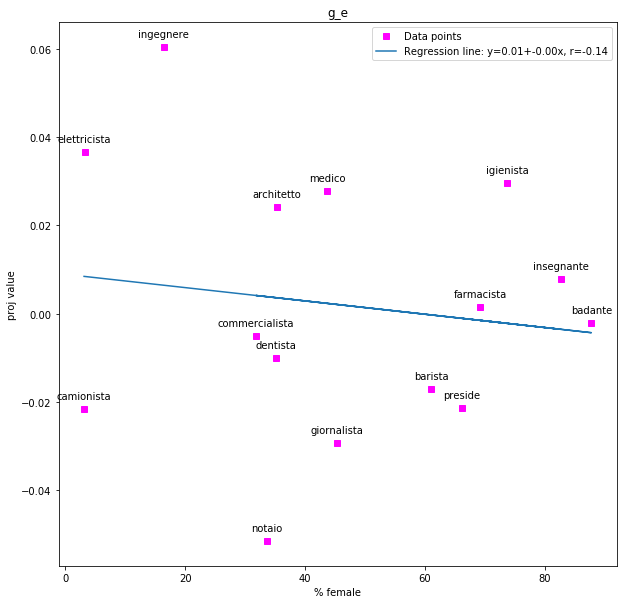

In [79]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/correlation/g_g_e')

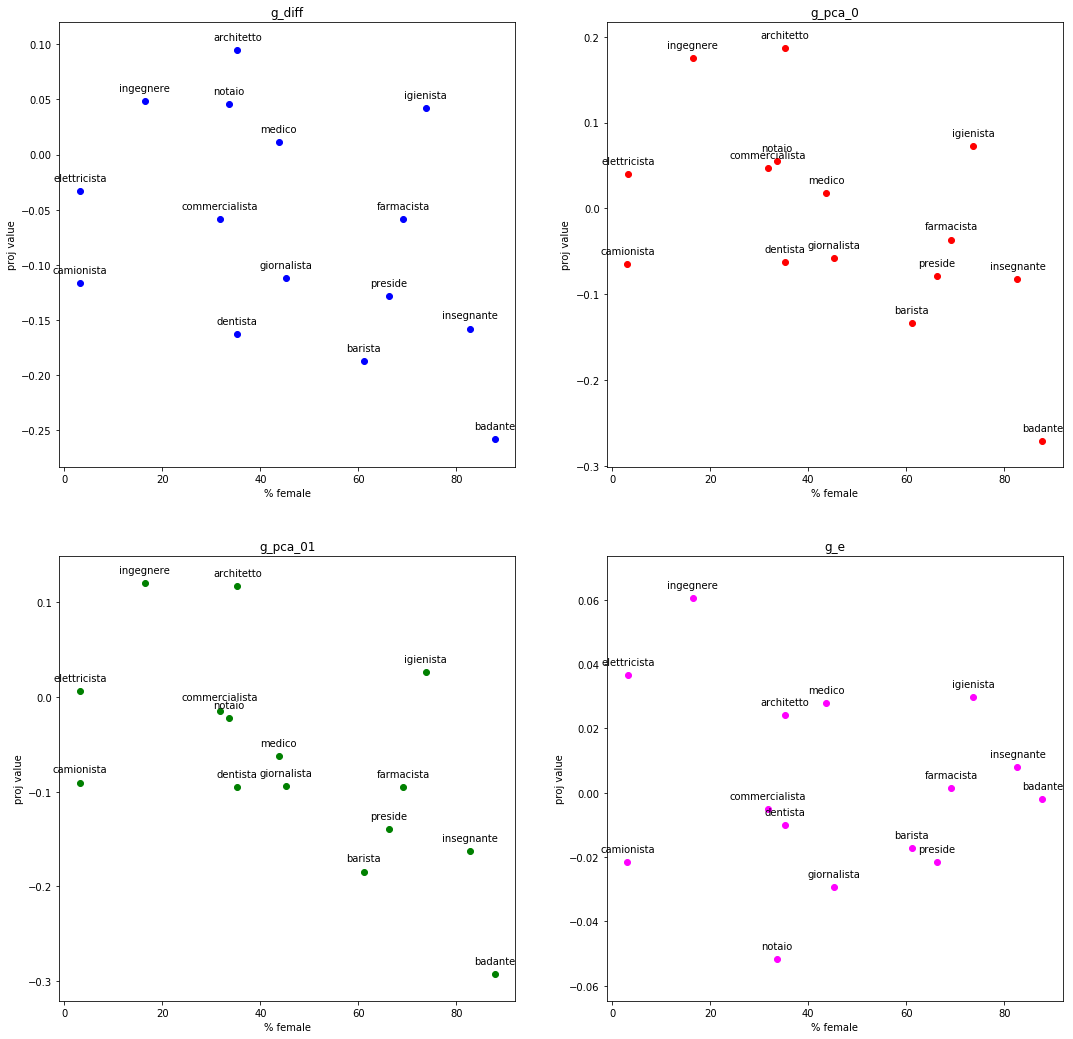

In [80]:
# scatter plots

plt.figure(figsize=(18,18))    

ax1 = plt.subplot(221)
ax1.scatter(ung_col6, ung_col1, c='blue')
ax1.set_title('g_diff')
ax1.set_xlabel('% female')
ax1.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax2 = plt.subplot(222)
ax2.scatter(ung_col6, ung_col2, c='red')
ax2.set_title('g_pca_0')
ax2.set_xlabel('% female')
ax2.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax3 = plt.subplot(223)
ax3.scatter(ung_col6, ung_col3, c='green')
ax3.set_title('g_pca_01')
ax3.set_xlabel('% female')
ax3.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
ax4 = plt.subplot(224)
ax4.scatter(ung_col6, ung_col4, c='magenta')
ax4.set_title('g_e')
ax4.set_xlabel('% female')
ax4.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()
fig.savefig('plot/ung/scatter/g_all')

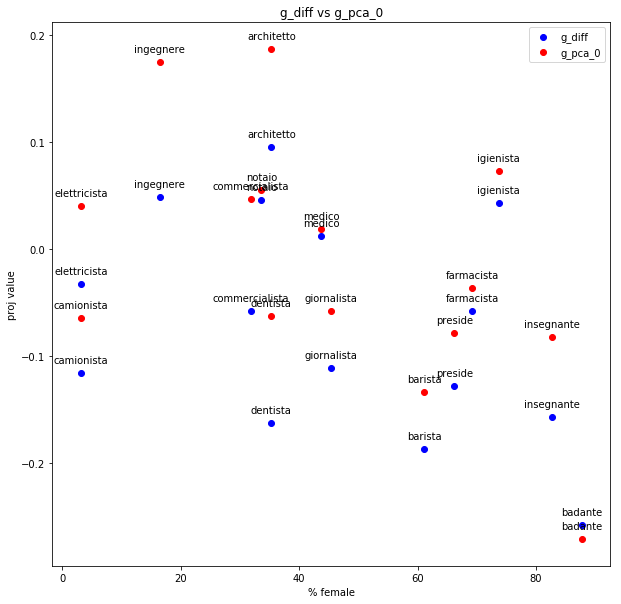

In [81]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.set_title('g_diff vs g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/g_g_diff_vs_g_pca_0')

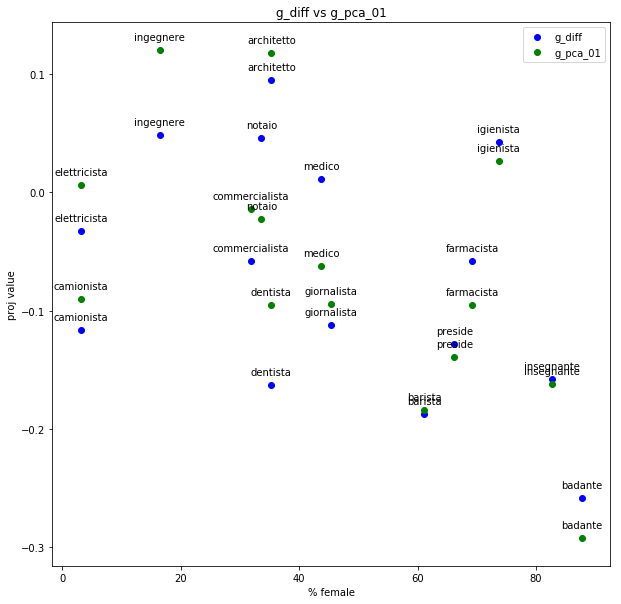

In [82]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_diff vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/g_g_diff_vs_g_pca_01')

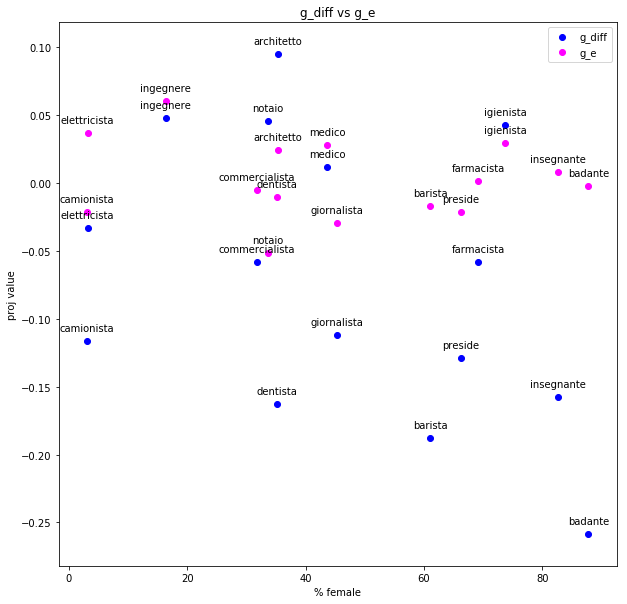

In [83]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_diff vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/g_g_diff_vs_g_e')

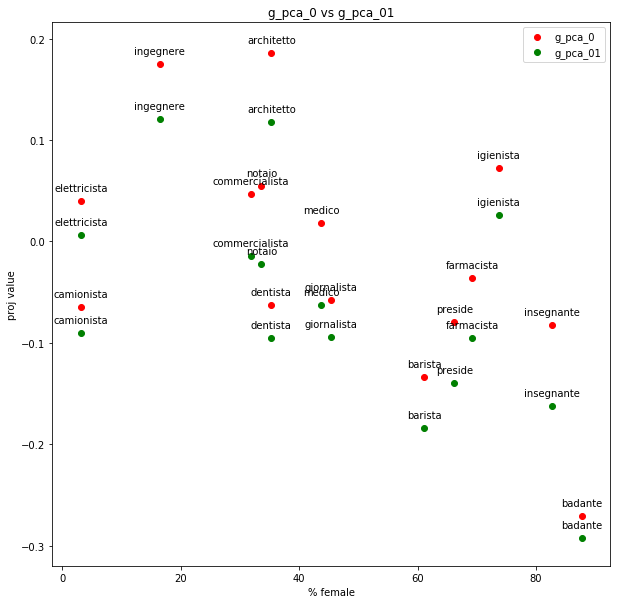

In [84]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_pca_0 vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/g_g_pca_0_vs_g_pca_01')

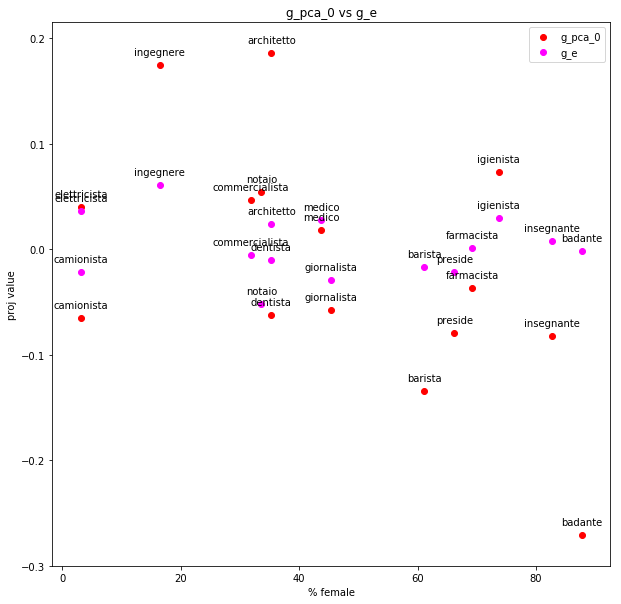

In [85]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_0 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/g_g_pca_0_vs_g_e')

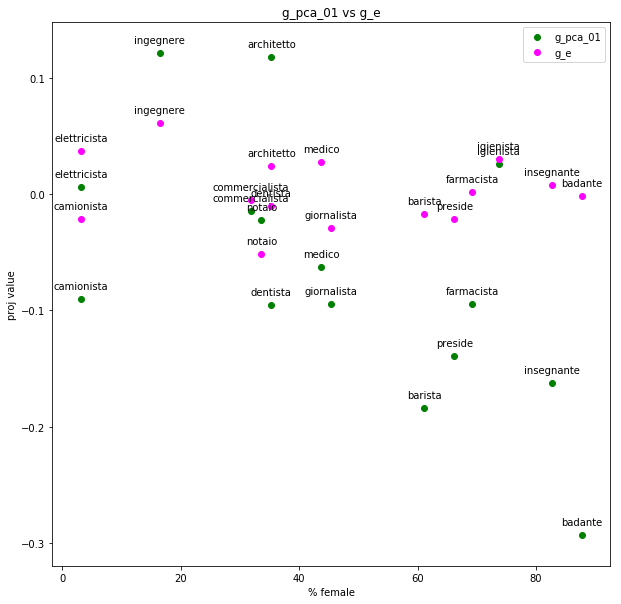

In [86]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_01 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/ung/scatter/g_g_pca_01_vs_g_e')

##### Gendered professions

In [87]:
# read professions
prof_gen_truth = db.read('professions_gen.csv', 'truth-mf')

In [88]:
# compute projection of each profession on g_diff
proj_gen_g_diff = db.prof_proj(E_g, prof_gen_truth, g_diff, 'istat-mf')

# compute projection of each profession on g_pca_0
proj_gen_g_pca_0 = db.prof_proj(E_g, prof_gen_truth, g_pca_0, 'istat-mf')

# compute projection of each profession on g_pca_01
proj_gen_g_pca_01 = db.prof_proj(E_g, prof_gen_truth, g_pca_01, 'istat-mf')

# compute projection of each profession on g_e
proj_gen_g_e = db.prof_proj(E_g, prof_gen_truth, g_e, 'istat-mf')

In [89]:
# print results
gen_col0 = [] # pandas columns
gen_col1 = []
gen_col2 = []
gen_col3 = []
gen_col4 = []
gen_col5 = []
gen_col6 = []
gen_col7 = []
gen_col8 = []
gen_col9 = []
gen_col10 = []

for i in range(len(proj_gen_g_diff)):
    gen_col0.append(proj_gen_g_diff[i][0]) # male profession
    gen_col1.append(proj_gen_g_diff[i][1]) # male projection on g_diff
    gen_col2.append(-proj_gen_g_pca_0[i][1]) # male projection on g_pca_0
    gen_col3.append(-proj_gen_g_pca_01[i][1]) # male projection on g_pca_01
    gen_col4.append(-np.real(proj_gen_g_e[i][1])) # male projection on g_e
    gen_col5.append(proj_gen_g_diff[i][2]) # female profession
    gen_col6.append(proj_gen_g_diff[i][3]) # female projection on g_diff
    gen_col7.append(-proj_gen_g_pca_0[i][3]) # female projection on g_pca_0
    gen_col8.append(-proj_gen_g_pca_01[i][3]) # female projection on g_pca_01
    gen_col9.append(-np.real(proj_gen_g_e[i][3])) # female projection on g_e
    gen_col10.append(proj_gen_g_diff[i][4]) # %female
    
gen_data = {'Male profession':gen_col0, 
           'M-Proj g_diff':gen_col1,
           'M-Proj g_pca_0':gen_col2, 
           'M-Proj g_pca_01':gen_col3,
           'M-Prog g_e':gen_col4,
           'Female profession':gen_col5, 
           'F-Proj g_diff':gen_col6,
           'F-Proj g_pca_0':gen_col7, 
           'F-Proj g_pca_01':gen_col8,
           'F-Prog g_e':gen_col9,  
           '% female':gen_col10}

gen_table = pd.DataFrame(gen_data)
gen_table

,Male profession,M-Proj g_diff,M-Proj g_pca_0,M-Proj g_pca_01,M-Prog g_e,Female profession,F-Proj g_diff,F-Proj g_pca_0,F-Proj g_pca_01,F-Prog g_e,% female
0,biologo,0.034183,0.093461,0.075028,0.044190,biologa,-0.212560,-0.265112,-0.271275,-0.001866,76.0
1,avvocato,-0.037062,0.129062,0.058017,-0.027940,avvocatessa,-0.254444,-0.224026,-0.208353,0.001100,47.2
2,psicologo,-0.044157,0.026535,-0.016280,-0.006756,psicologa,-0.286778,-0.343406,-0.315514,-0.049775,82.9
3,maestro,0.088839,0.118162,-0.005922,-0.060189,maestra,-0.219276,-0.240546,-0.260523,-0.048168,96.4
4,professore,-0.032111,0.055725,-0.024257,0.059632,professoressa,-0.270093,-0.320515,-0.307693,-0.031977,71.9
5,cameriere,-0.114928,-0.032919,-0.107858,-0.020555,cameriera,-0.310950,-0.362993,-0.319444,-0.037913,51.4
6,infermiere,-0.047930,-0.094381,-0.072629,-0.036522,infermiera,-0.258774,-0.285713,-0.239436,-0.039524,77.0
7,filosofo,0.135867,0.140866,0.031013,-0.021475,filosofa,-0.103877,-0.181049,-0.202317,-0.027595,51.9
8,ostetrico,0.021003,0.082348,-0.020919,0.026987,ostetrica,-0.099285,-0.115064,-0.140822,0.009814,98.3
9,veterinario,-0.083075,0.017559,-0.041211,0.051057,veterinaria,-0.055184,-0.066286,-0.060508,-0.053645,59.2


In [90]:
gen_table.to_csv('truth_gen_g.csv', index=False)

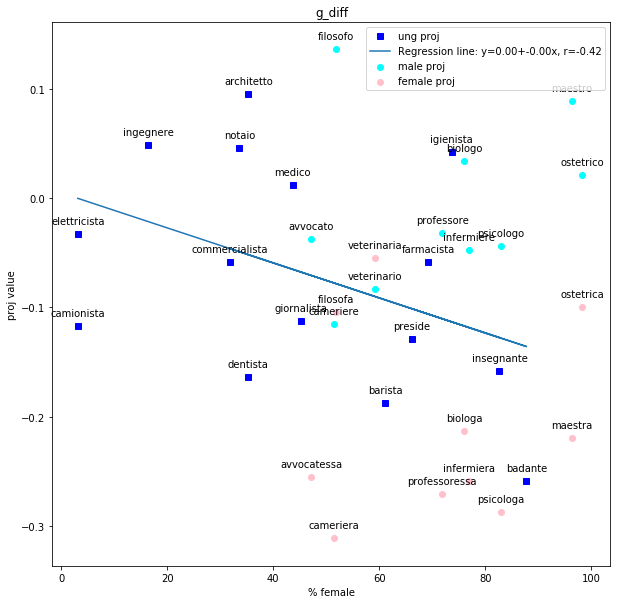

In [91]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col1, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col6, c='pink', label='female proj')
ax.set_title('g_diff')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/gen/g_g_diff')

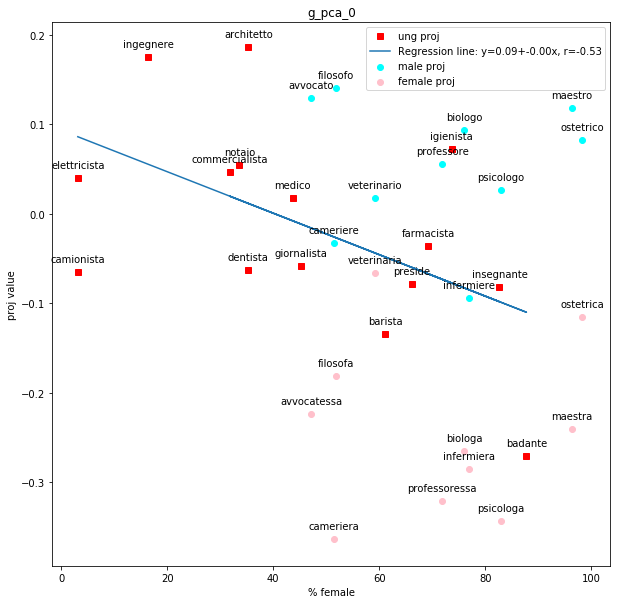

In [92]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col2, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col7, c='pink', label='female proj')
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.show()
fig.savefig('plot/gen/g_g_pca_0')

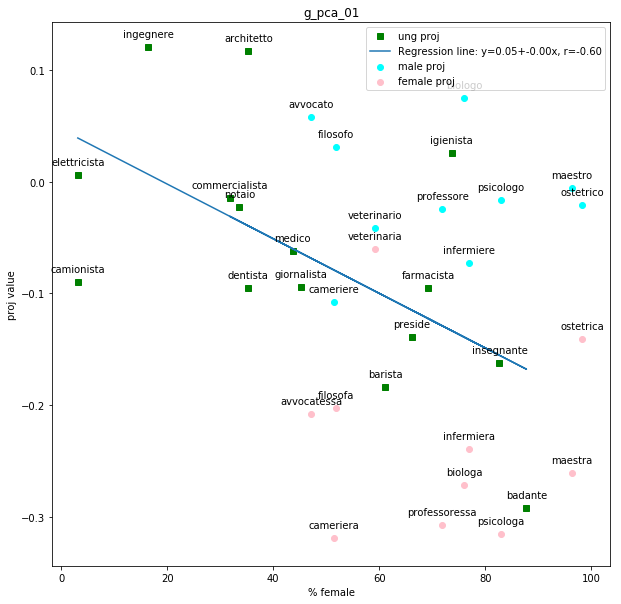

In [93]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col3, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col8, c='pink', label='female proj')
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col8[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/gen/g_g_pca_01')

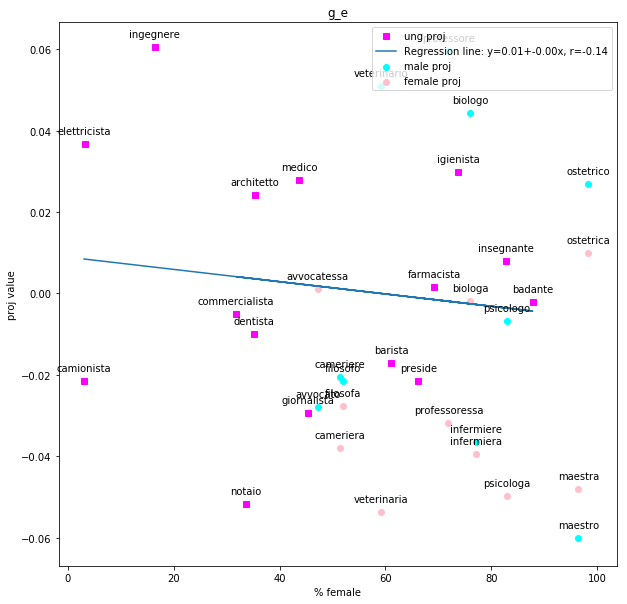

In [94]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col4, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col9, c='pink', label='female proj')
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col9[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('plot/gen/g_g_e')

##### Ungendered + mean gendered professions

In [95]:
# print mean results
mean_col0 = []
mean_col1 = []
mean_col2 = []
mean_col3 = []
mean_col4 = []
mean_col5 = []

for i in range(len(proj_ung_g_diff)):
    mean_col0.append(proj_ung_g_diff[i][0]) # profession
    mean_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    mean_col2.append(-proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    mean_col3.append(-proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    mean_col4.append(-np.real(proj_ung_g_e[i][1])) # projection on g_e
    mean_col5.append(proj_ung_g_diff[i][3]) # %female
    
for i in range(len(proj_gen_g_diff)):
    mean_col0.append(proj_gen_g_diff[i][0]) # profession
    mean_col1.append((proj_gen_g_diff[i][1]+proj_gen_g_diff[i][3])/2) # mean projection on g_diff
    mean_col2.append(-(proj_gen_g_pca_0[i][1]+proj_gen_g_pca_0[i][3])/2) # mean projection on g_pca_0
    mean_col3.append(-(proj_gen_g_pca_01[i][1]+proj_gen_g_pca_01[i][3])/2) # mean projection on g_pca_01
    mean_col4.append(-(np.real(proj_gen_g_e[i][1])+np.real(proj_gen_g_e[i][3]))/2) # mean projection on g_e
    mean_col5.append(proj_gen_g_diff[i][4]) # %female
    
mean_data = {'Profession':mean_col0, 
           'Proj g_diff':mean_col1,
           'Proj g_pca_0':mean_col2, 
           'Proj g_pca_01':mean_col3,
           'Prog g_e':mean_col4, 
           '% female':mean_col5}

mean_table = pd.DataFrame(mean_data)
mean_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% female
0,camionista,-0.116571,-0.065065,-0.090247,-0.021633,3.1
1,elettricista,-0.032968,0.039751,0.006391,0.036579,3.2
2,ingegnere,0.048153,0.174863,0.120834,0.060551,16.4
3,architetto,0.094760,0.186434,0.117584,0.024187,35.3
4,notaio,0.045788,0.054650,-0.022539,-0.051675,33.6
5,commercialista,-0.058101,0.046732,-0.014279,-0.005193,31.8
6,giornalista,-0.111980,-0.057983,-0.094459,-0.029385,45.3
7,insegnante,-0.157774,-0.082164,-0.162323,0.007874,82.7
8,barista,-0.187549,-0.134068,-0.184296,-0.017124,61.1
9,medico,0.011663,0.018053,-0.062328,0.027769,43.7


In [96]:
# pearson correlation
r_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[0]
r_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[0]
r_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[0]
r_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[0]

p_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[1]
p_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[1]
p_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[1]
p_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[1]

In [97]:
pearson_data = {'g_diff':[r_mean_g_diff,p_mean_g_diff],
                'g_pca_0':[r_mean_g_pca_0,p_mean_g_pca_0],
                'g_pca_01':[r_mean_g_pca_01,p_mean_g_pca_01],
                'g_e':[r_mean_g_e,p_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.340991,-0.516180,-0.566300,-0.208670
p,0.095298,0.008255,0.003167,0.316821


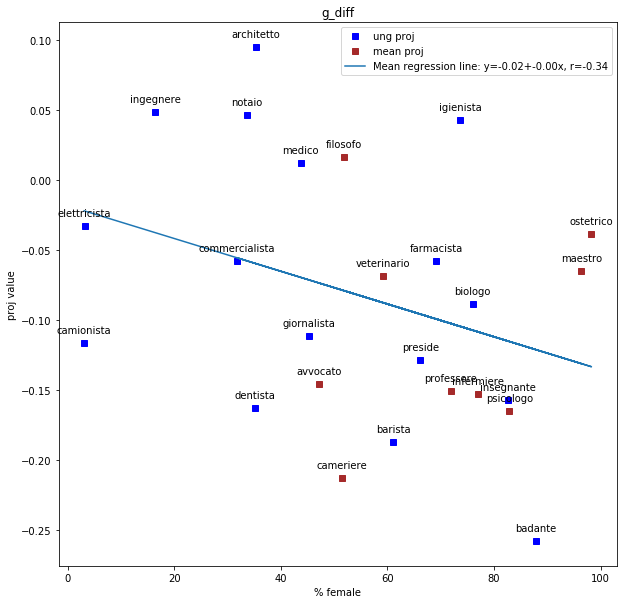

In [98]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col1[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col1[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_diff')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/g_g_diff')

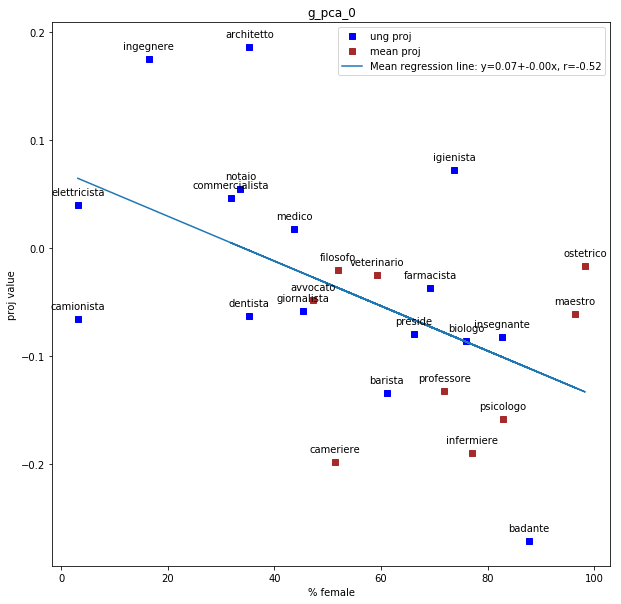

In [99]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col2)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col2[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col2[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/g_g_pca_0')

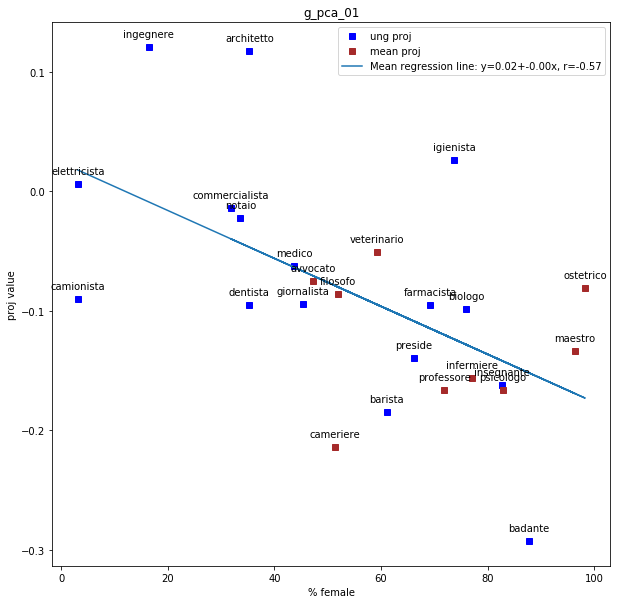

In [100]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col3)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col3[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col3[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/g_g_pca_01')

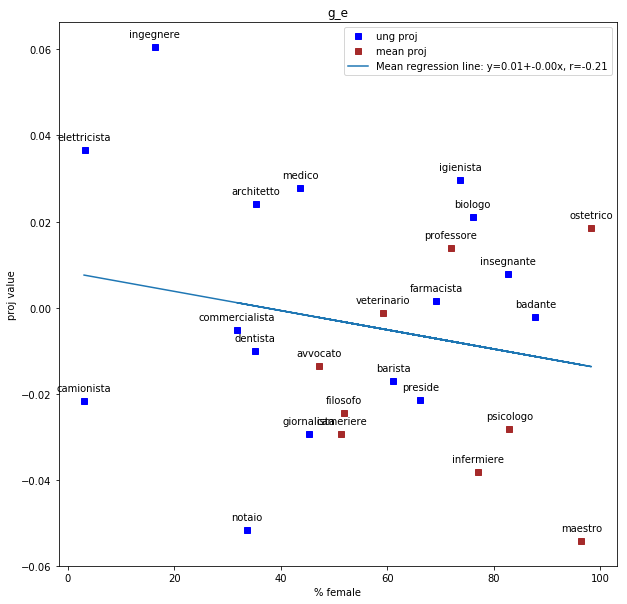

In [101]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col4)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col4[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col4[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
fig.savefig('plot/mean/g_g_e')